# Quantitative Crypto Research - Orderbook Feature Analysis

## Research Context

**Researcher**: Senior Quant - Crypto Markets  
**Goal**: Extract alpha from high-frequency orderbook microstructure  
**Asset**: BTC-USD on Coinbase Advanced  
**Data**: 197 engineered features from L2 orderbook snapshots + trades

### Research Questions

1. **Can orderbook microstructure predict short-term price direction?**
2. **Which features carry the most predictive signal?**
3. **What are the optimal prediction horizons for our feature frequency?**
4. **How do different ML models compare on this high-frequency data?**

### Key References
- Cont et al. (2014): Order Flow Imbalance (OFI) predicts price changes
- Kyle (1985): Lambda measures market impact
- López de Prado (2018): Financial ML best practices

---

## 1. Setup & Data Loading

In [1]:
# Core imports
import os
import sys
import warnings
from pathlib import Path
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import polars as pl

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ML
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, mean_squared_error, r2_score
)

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

print(f"Research session started: {datetime.now()}")
print(f"Polars version: {pl.__version__}")

Research session started: 2026-02-04 01:24:55.812662
Polars version: 1.36.1


In [13]:
# ============================================================================
# DATA CONFIGURATION
# ============================================================================

# Paths
DATA_ROOT = Path(os.getcwd()).parent.absolute() / "data/processed/silver/orderbook"
EXCHANGE = "coinbaseadvanced"

In [14]:
ROOT_PL_DF = pl.scan_parquet(DATA_ROOT / "**/*.parquet", hive_partitioning = True)
ROOT_PL_DF = ROOT_PL_DF.filter(
                (pl.col("exchange") == EXCHANGE) &
                    (pl.col("year") == 2025) &
                    (pl.col("month") == 12) &
                    (pl.col("day") == 14)
                )

In [15]:
ALL_SYMBOLS = ROOT_PL_DF.select("symbol").unique().collect().to_series().to_list()
len(ALL_SYMBOLS)

22

## Multi-Asset Horizontal Concatenation

Build a wide-format DataFrame where each row represents a 1-second time slice across ALL symbols.
- Resamples each symbol to 1s frequency using ASOF semantics (point-in-time safe)
- Horizontally concatenates: `{symbol}_{feature}` naming convention
- Keeps only rows where ALL symbols have data (inner join semantics)

In [16]:
# ============================================================================
# MULTI-ASSET HORIZONTAL CONCATENATION (LAZY)
# ============================================================================
# Strategy:
#   1. For each symbol, filter ROOT_PL_DF lazily
#   2. Resample to 1s using ASOF semantics (point-in-time safe)
#   3. Rename all feature columns with symbol prefix
#   4. Join all symbol LazyFrames on timestamp (inner join = only complete rows)
#   5. Collect() only at the very end

import sys
sys.path.insert(0, str(Path(os.getcwd()).parent.absolute()))

from etl.utils.resampling import resample_timeseries

# Configuration
RESAMPLE_FREQ = "1s"  # 1-second frequency for alignment
META_COLS = ['timestamp', 'capture_ts', 'symbol', 'exchange', 'year', 'month', 'day', 'hour']

# Get schema to identify feature columns (exclude meta/partition columns)
schema = ROOT_PL_DF.collect_schema()
all_cols = schema.names()
feature_cols = [c for c in all_cols if c not in META_COLS]

print(f"Symbols to concatenate: {len(ALL_SYMBOLS)}")
print(f"Features per symbol: {len(feature_cols)}")
print(f"Expected total features: {len(ALL_SYMBOLS) * len(feature_cols)}")
print(f"\nFeature columns: {feature_cols[:10]}...")  # Preview first 10

Symbols to concatenate: 22
Features per symbol: 197
Expected total features: 4334

Feature columns: ['collected_at', 'nonce', 'bid_price_L0', 'bid_size_L0', 'ask_price_L0', 'ask_size_L0', 'bid_price_L1', 'bid_size_L1', 'ask_price_L1', 'ask_size_L1']...


In [17]:
# ============================================================================
# BUILD MULTI-ASSET LAZY FRAME (STREAMING-FRIENDLY)
# ============================================================================
# Key insight: Polars LazyFrame joins work but require careful orchestration.
# We use a fold-style join: start with first symbol, join subsequent symbols.
#
# Why this works:
#   - Each symbol_lf is filtered lazily (no collect)
#   - Resampling is lazy (group_by + agg = lazy)
#   - Join is lazy (inner join on timestamp)
#   - Only final .collect() materializes the result
#
# Memory consideration:
#   - The query optimizer will push down predicates
#   - Each symbol's data streams through the pipeline
#   - Only the aligned, resampled result needs to fit in memory

def build_multi_asset_lf(
    root_lf: pl.LazyFrame,
    symbols: list[str],
    frequency: str = "1s",
    feature_cols: list[str] = None,
    timestamp_col: str = "timestamp",
) -> pl.LazyFrame:
    """
    Build a horizontally concatenated multi-asset LazyFrame.
    
    Each symbol's features are prefixed with the symbol name (sanitized).
    Timestamps are aligned via inner join (only rows with ALL symbols' data).
    
    Args:
        root_lf: Root LazyFrame with all symbols (partition-scanned)
        symbols: List of symbols to include
        frequency: Resample frequency (e.g., "1s", "1m")
        feature_cols: Feature columns to include (auto-detected if None)
        timestamp_col: Name of timestamp column
    
    Returns:
        LazyFrame with columns: timestamp, {symbol1}_{feat1}, {symbol1}_{feat2}, ...
    """
    if not symbols:
        raise ValueError("At least one symbol required")
    
    # Auto-detect feature columns if not provided
    if feature_cols is None:
        schema = root_lf.collect_schema()
        meta = ['timestamp', 'capture_ts', 'symbol', 'exchange', 'year', 'month', 'day', 'hour',
                'original_timestamp', 'snapshot_count', 'data_staleness']
        feature_cols = [c for c in schema.names() if c not in meta]
    
    def sanitize_symbol(s: str) -> str:
        """Convert symbol to valid column name prefix (BTC/USD -> BTC_USD)"""
        return s.replace("/", "_").replace("-", "_").replace(".", "_")
    
    def process_symbol(symbol: str) -> pl.LazyFrame:
        """Filter, resample, and rename columns for one symbol."""
        # Filter lazily by symbol partition
        symbol_lf = root_lf.filter(pl.col("symbol") == symbol)
        
        # Resample to target frequency using ASOF semantics
        # This uses our etl/utils/resampling logic
        resampled = resample_timeseries(
            symbol_lf,
            frequency=frequency,
            value_cols=feature_cols,
            agg_method="last",  # ASOF: last known value
            group_cols=[],  # No grouping needed (already filtered by symbol)
            timestamp_col=timestamp_col,
            add_staleness=False,  # Skip staleness calc for performance
        )
        
        # Rename feature columns with symbol prefix
        prefix = sanitize_symbol(symbol)
        rename_map = {col: f"{prefix}_{col}" for col in feature_cols if col in resampled.collect_schema().names()}
        
        # Select only timestamp + renamed features
        select_cols = ["timestamp"] + list(rename_map.keys())
        return resampled.select(select_cols).rename(rename_map)
    
    # Process first symbol as base
    print(f"Processing {symbols[0]}...")
    result_lf = process_symbol(symbols[0])
    
    # Fold-join remaining symbols
    for i, symbol in enumerate(symbols[1:], start=2):
        print(f"Processing {symbol} ({i}/{len(symbols)})...")
        symbol_lf = process_symbol(symbol)
        
        # Inner join on timestamp (keeps only rows where both have data)
        result_lf = result_lf.join(
            symbol_lf,
            on="timestamp",
            how="inner"
        )
    
    # Sort by timestamp
    return result_lf.sort("timestamp")

# Build the multi-asset LazyFrame
print("=" * 60)
print("BUILDING MULTI-ASSET LAZYFRAME")
print("=" * 60)

multi_asset_lf = build_multi_asset_lf(
    root_lf=ROOT_PL_DF,
    symbols=ALL_SYMBOLS,
    frequency=RESAMPLE_FREQ,
    feature_cols=feature_cols,
)

# Preview the query plan (no execution yet!)
print("\n✅ LazyFrame built successfully (not yet collected)")
print(f"Query plan optimized by Polars engine")
print(f"\nSchema preview (first 20 columns):")
preview_schema = multi_asset_lf.collect_schema()
for i, (name, dtype) in enumerate(preview_schema.items()):
    if i >= 20:
        print(f"  ... and {len(preview_schema) - 20} more columns")
        break
    print(f"  {name}: {dtype}")

BUILDING MULTI-ASSET LAZYFRAME
Processing AAVE-USD...
Processing ADA-USD (2/22)...
Processing AVAX-USD (3/22)...
Processing BCH-USD (4/22)...
Processing BTC-USD (5/22)...
Processing DOGE-USD (6/22)...
Processing ETH-USD (7/22)...
Processing FARTCOIN-USD (8/22)...
Processing HBAR-USD (9/22)...
Processing ICP-USD (10/22)...
Processing LINK-USD (11/22)...
Processing LTC-USD (12/22)...
Processing MON-USD (13/22)...
Processing ONDO-USD (14/22)...
Processing PENGU-USD (15/22)...
Processing SOL-USD (16/22)...
Processing SUI-USD (17/22)...
Processing TAO-USD (18/22)...
Processing UNI-USD (19/22)...
Processing XLM-USD (20/22)...
Processing XRP-USD (21/22)...
Processing ZEC-USD (22/22)...

✅ LazyFrame built successfully (not yet collected)
Query plan optimized by Polars engine

Schema preview (first 20 columns):
  timestamp: Datetime(time_unit='ms', time_zone=None)
  AAVE_USD_collected_at: Int64
  AAVE_USD_nonce: Int64
  AAVE_USD_bid_price_L0: Float64
  AAVE_USD_bid_size_L0: Float64
  AAVE_USD_a

In [18]:
# ============================================================================
# COLLECT THE MULTI-ASSET DATAFRAME
# ============================================================================
# This is where the actual computation happens. Polars will:
#   1. Read each symbol's partition files
#   2. Apply resampling transformations
#   3. Execute the join chain
#   4. Return the final aligned DataFrame
#
# Memory estimate: ~(n_symbols × n_timestamps × n_features × 8 bytes)
# For 10 symbols, 86400 seconds/day, 50 features each:
#   10 × 86400 × 50 × 8 = ~345 MB per day

print("=" * 60)
print("COLLECTING MULTI-ASSET DATAFRAME")
print("=" * 60)
print("⏳ Executing query plan (this may take a while for large datasets)...")

import time
start_time = time.perf_counter()

# COLLECT - this is the only materialization point!
multi_asset_df = multi_asset_lf.collect()

elapsed = time.perf_counter() - start_time
print(f"\n✅ Collection complete in {elapsed:.1f} seconds")
print(f"   Shape: {multi_asset_df.shape[0]:,} rows × {multi_asset_df.shape[1]:,} columns")
print(f"   Memory: {multi_asset_df.estimated_size('mb'):.1f} MB")
print(f"   Time range: {multi_asset_df['timestamp'].min()} to {multi_asset_df['timestamp'].max()}")

# Verify no nulls (inner join should guarantee this)
null_counts = multi_asset_df.null_count().sum_horizontal()[0]
print(f"   Null values: {null_counts} (should be 0 due to inner join)")

# Show sample
print("\n📊 Sample (first 5 rows, first 10 columns):")
display_cols = multi_asset_df.columns[:10]
print(multi_asset_df.select(display_cols).head(5))

COLLECTING MULTI-ASSET DATAFRAME
⏳ Executing query plan (this may take a while for large datasets)...

✅ Collection complete in 11.5 seconds
   Shape: 3,114 rows × 4,335 columns
   Memory: 102.9 MB
   Time range: 2025-12-14 00:00:03 to 2025-12-14 02:59:56
   Null values: 152210 (should be 0 due to inner join)

📊 Sample (first 5 rows, first 10 columns):
shape: (5, 10)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ timestamp ┆ AAVE_USD_ ┆ AAVE_USD_ ┆ AAVE_USD_ ┆ … ┆ AAVE_USD_ ┆ AAVE_USD_ ┆ AAVE_USD_ ┆ AAVE_USD │
│ ---       ┆ collected ┆ nonce     ┆ bid_price ┆   ┆ ask_size_ ┆ bid_price ┆ bid_size_ ┆ _ask_pri │
│ datetime[ ┆ _at       ┆ ---       ┆ _L0       ┆   ┆ L0        ┆ _L1       ┆ L1        ┆ ce_L1    │
│ ms]       ┆ ---       ┆ i64       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆ i64       ┆           ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════

### Alternative: Streaming Sink for Memory-Constrained Scenarios

If the collected DataFrame exceeds available RAM, use Polars' **streaming sink** to write directly to Parquet without full materialization:

In [ ]:
# ============================================================================
# STREAMING SINK (FOR DATASETS TOO LARGE TO FIT IN MEMORY)
# ============================================================================
# If multi_asset_lf.collect() causes OOM, use this instead.
#
# Polars streaming mode processes data in batches, writing directly to disk.
# Caveats:
#   - Not all operations support streaming (joins are tricky)
#   - May need to process in chunks manually for complex joins
#
# Option 1: Native streaming sink (if supported by query plan)
# Option 2: Chunked processing with manual batching

# --- Option 1: Try native streaming sink ---
# This works if the query plan is streaming-compatible
STREAMING_OUTPUT_PATH = DATA_ROOT.parent / "multi_asset_aligned_1s.parquet"

def try_streaming_sink(lf: pl.LazyFrame, output_path: Path) -> bool:
    """
    Attempt to use Polars streaming sink. Returns True if successful.
    Falls back gracefully if query plan doesn't support streaming.
    """
    try:
        print(f"Attempting streaming sink to {output_path}...")
        lf.sink_parquet(
            output_path,
            compression="zstd",
            compression_level=3,
        )
        print(f"✅ Streaming sink successful!")
        return True
    except Exception as e:
        print(f"⚠️ Streaming sink not supported for this query: {e}")
        return False

# --- Option 2: Chunked processing (fallback for complex joins) ---
def chunked_multi_asset_build(
    root_lf: pl.LazyFrame,
    symbols: list[str],
    frequency: str = "1s",
    feature_cols: list[str] = None,
    chunk_duration: str = "1d",  # Process 1 day at a time
    output_dir: Path = None,
) -> pl.LazyFrame:
    """
    Build multi-asset DataFrame in time-based chunks to manage memory.
    
    This approach:
    1. Determines the full time range from the data
    2. Processes each time chunk independently
    3. Writes chunks to separate Parquet files
    4. Returns a lazy scan over all chunks
    
    Useful when the full join doesn't fit in memory.
    """
    if output_dir is None:
        output_dir = DATA_ROOT.parent / "multi_asset_chunks"
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Get time range (this requires a small collect)
    print("Determining time range...")
    time_bounds = root_lf.select(
        pl.col("timestamp").min().alias("min_ts"),
        pl.col("timestamp").max().alias("max_ts"),
    ).collect()
    min_ts = time_bounds["min_ts"][0]
    max_ts = time_bounds["max_ts"][0]
    print(f"  Time range: {min_ts} to {max_ts}")
    
    # Generate chunk boundaries
    chunk_files = []
    current_start = min_ts
    chunk_idx = 0
    
    while current_start < max_ts:
        current_end = current_start + pl.duration(days=1) if chunk_duration == "1d" else current_start + pl.duration(hours=1)
        current_end = min(current_end, max_ts)
        
        print(f"\nProcessing chunk {chunk_idx}: {current_start} to {current_end}")
        
        # Filter root_lf to this time range
        chunk_root = root_lf.filter(
            (pl.col("timestamp") >= current_start) & (pl.col("timestamp") < current_end)
        )
        
        # Build multi-asset for this chunk
        chunk_lf = build_multi_asset_lf(
            root_lf=chunk_root,
            symbols=symbols,
            frequency=frequency,
            feature_cols=feature_cols,
        )
        
        # Write chunk
        chunk_path = output_dir / f"chunk_{chunk_idx:04d}.parquet"
        chunk_lf.collect().write_parquet(chunk_path, compression="zstd")
        chunk_files.append(chunk_path)
        print(f"  Written: {chunk_path}")
        
        current_start = current_end
        chunk_idx += 1
    
    # Return lazy scan over all chunks
    print(f"\n✅ Wrote {len(chunk_files)} chunks to {output_dir}")
    return pl.scan_parquet(output_dir / "*.parquet")

# Uncomment to use streaming/chunked approaches:
# success = try_streaming_sink(multi_asset_lf, STREAMING_OUTPUT_PATH)
# if not success:
#     multi_asset_lf = chunked_multi_asset_build(ROOT_PL_DF, ALL_SYMBOLS, RESAMPLE_FREQ, feature_cols)

print("💡 TIP: If collect() causes OOM, uncomment the streaming/chunked code above")

In [8]:
ALL_SYMBOLS = ROOT_PL_DF.select("symbol").unique().collect().to_series().to_list()

In [ ]:
ROOT_PL_DF.group_by()

In [9]:
ALL_SYMBOLS

['AAVE-USD',
 'ADA-USD',
 'AVAX-USD',
 'BCH-USD',
 'BTC-USD',
 'DOGE-USD',
 'ETH-USD',
 'FARTCOIN-USD',
 'HBAR-USD',
 'ICP-USD',
 'LINK-USD',
 'LTC-USD',
 'MON-USD',
 'ONDO-USD',
 'PENGU-USD',
 'SOL-USD',
 'SUI-USD',
 'TAO-USD',
 'UNI-USD',
 'XLM-USD',
 'XRP-USD',
 'ZEC-USD']

In [ ]:
# Loading modes (use SAMPLE_LIGHT_MODE when running other heavy processes)
SAMPLE_LIGHT_MODE = False   # Load only 1 hour (~minimal memory)
SAMPLE_MODE = True         # Load 1 day (ignored if SAMPLE_LIGHT_MODE=True)
# Set both to False for full dataset

if SAMPLE_LIGHT_MODE:
    # Load single hour partition - minimal memory footprint
    sample_path = DATA_ROOT / f"exchange={EXCHANGE}/symbol={SYMBOL}/year=2026/month=1/day=26/hour=9"
    print(f"⚡ LIGHT MODE: Loading single hour from {sample_path}")
    scan_path = sample_path / "*.parquet"
elif SAMPLE_MODE:
    # Load specific partition for fast iteration (1 day)
    sample_path = DATA_ROOT / f"exchange={EXCHANGE}/symbol={SYMBOL}/year=2026/month=1/day=1"
    print(f"📊 Sample mode: Loading 1 day from {sample_path}")
    scan_path = sample_path / "**/*.parquet"
else:
    # Full lazy scan for production
    full_path = DATA_ROOT / f"exchange={EXCHANGE}/symbol={SYMBOL}/**/*.parquet"
    print(f"🚀 Full mode: Scanning {full_path}")
    scan_path = full_path

In [ ]:
pl_df = pl.scan_parquet(scan_path)

# Do lazy transformations here:
# ...

In [ ]:
df = pl_df.collect()
print(f"\nLoaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory: {df.estimated_size('mb'):.1f} MB")

In [2]:


# Loading modes (use SAMPLE_LIGHT_MODE when running other heavy processes)
SAMPLE_LIGHT_MODE = False   # Load only 1 hour (~minimal memory)
SAMPLE_MODE = True         # Load 1 day (ignored if SAMPLE_LIGHT_MODE=True)
# Set both to False for full dataset

if SAMPLE_LIGHT_MODE:
    # Load single hour partition - minimal memory footprint
    sample_path = DATA_ROOT / f"exchange={EXCHANGE}/symbol={SYMBOL}/year=2026/month=1/day=26/hour=9"
    print(f"⚡ LIGHT MODE: Loading single hour from {sample_path}")
    scan_path = sample_path / "*.parquet"
elif SAMPLE_MODE:
    # Load specific partition for fast iteration (1 day)
    sample_path = DATA_ROOT / f"exchange={EXCHANGE}/symbol={SYMBOL}/year=2026/month=1/day=1"
    print(f"📊 Sample mode: Loading 1 day from {sample_path}")
    df = pl.read_parquet(f"{sample_path}/**/*.parquet")
else:
    # Full lazy scan for production
    full_path = DATA_ROOT / f"exchange={EXCHANGE}/symbol={SYMBOL}/**/*.parquet"
    print(f"🚀 Full mode: Scanning {full_path}")
    df = pl.scan_parquet(str(full_path)).collect()

print(f"\nLoaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory: {df.estimated_size('mb'):.1f} MB")

📊 Sample mode: Loading 1 day from c:\Users\longp\market-data-pipeline\data\processed\silver\orderbook\exchange=coinbaseadvanced\symbol=BTC-USD\year=2026\month=1\day=1

Loaded: 964,662 rows × 205 columns
Memory: 1489.7 MB


In [3]:
# ============================================================================
# FEATURE CATEGORIZATION
# ============================================================================

# Define feature groups for analysis
FEATURE_GROUPS = {
    'meta': ['timestamp', 'capture_ts', 'symbol', 'exchange', 'year', 'month', 'day', 'hour'],
    'price_levels': [c for c in df.columns if 'price_L' in c],
    'size_levels': [c for c in df.columns if 'size_L' in c and 'bid' in c or 'ask' in c],
    'core_prices': ['best_bid', 'best_ask', 'mid_price', 'spread', 'relative_spread', 'microprice'],
    'imbalances': [c for c in df.columns if 'imbalance' in c.lower()],
    'depth': [c for c in df.columns if 'depth' in c.lower() or 'total_' in c],
    'ofi': [c for c in df.columns if 'ofi' in c.lower() or 'mlofi' in c.lower()],
    'dynamics': [c for c in df.columns if any(x in c for x in ['velocity', 'acceleration', 'log_return'])],
    'rolling': [c for c in df.columns if 'rolling' in c.lower() or 'realized_vol' in c or 'mean_' in c],
    'advanced': [c for c in df.columns if any(x in c for x in ['kyle', 'vpin', 'toxicity', 'lambda'])],
    'liquidity': [c for c in df.columns if any(x in c for x in ['vwap', 'smart', 'concentration', 'slope'])],
}

# Print summary
print("Feature Group Summary:")
print("=" * 50)
total_categorized = 0
for group, cols in FEATURE_GROUPS.items():
    existing = [c for c in cols if c in df.columns]
    print(f"{group:15s}: {len(existing):3d} features")
    total_categorized += len(existing)

# Find uncategorized
all_categorized = set()
for cols in FEATURE_GROUPS.values():
    all_categorized.update(cols)
uncategorized = [c for c in df.columns if c not in all_categorized]
print(f"{'uncategorized':15s}: {len(uncategorized):3d} features")
print(f"\nTotal columns: {len(df.columns)}")

Feature Group Summary:
meta           :   8 features
price_levels   :  40 features
size_levels    :  76 features
core_prices    :   6 features
imbalances     :   6 features
depth          :  12 features
ofi            :  14 features
dynamics       :   4 features
rolling        :  13 features
advanced       :   5 features
liquidity      :  16 features
uncategorized  :  43 features

Total columns: 205


## 2. Exploratory Data Analysis

In [4]:
# ============================================================================
# TEMPORAL ANALYSIS
# ============================================================================

# Check timestamp type first
print(f"Timestamp column dtype: {df['timestamp'].dtype}")

# Convert timestamp to proper datetime if needed (common: Unix ms stored as i64)
if df['timestamp'].dtype == pl.Int64:
    print("Converting Unix ms timestamp to Datetime...")
    df = df.with_columns([
        pl.from_epoch(pl.col('timestamp'), time_unit='ms').alias('timestamp_dt')
    ])
    ts_col = 'timestamp_dt'
elif df['timestamp'].dtype == pl.Datetime:
    ts_col = 'timestamp'
else:
    # Try to work with what we have
    ts_col = 'timestamp'

# Sort by timestamp
df = df.sort(ts_col)

# Calculate inter-arrival times
df = df.with_columns([
    (pl.col(ts_col).diff().dt.total_milliseconds() / 1000).alias('delta_seconds')
])

print("\n" + "=" * 60)
print("TEMPORAL ANALYSIS")
print("=" * 60)
print(f"  Start: {df[ts_col].min()}")
print(f"  End:   {df[ts_col].max()}")
print(f"  Duration: {df[ts_col].max() - df[ts_col].min()}")
print(f"  Total records: {len(df):,}")

print(f"\nInter-arrival time statistics (seconds):")
delta_stats = df.select('delta_seconds').drop_nulls().describe()
print(delta_stats)

# Key insight: data frequency
median_delta = df['delta_seconds'].median()
print(f"\n📊 DATA FREQUENCY INSIGHT:")
print(f"   Median inter-arrival: {median_delta:.3f} seconds")
if median_delta < 0.1:
    print(f"   → HIGH FREQUENCY data (sub-100ms updates)")
elif median_delta < 1.0:
    print(f"   → MODERATE FREQUENCY data (~{1/median_delta:.1f} updates/sec)")
else:
    print(f"   → LOW FREQUENCY data (~1 update every {median_delta:.1f}s)")

Timestamp column dtype: Int64
Converting Unix ms timestamp to Datetime...

TEMPORAL ANALYSIS
  Start: 2026-01-01 00:00:00.289000
  End:   2026-01-01 23:59:59.901000
  Duration: 23:59:59.612000
  Total records: 964,662

Inter-arrival time statistics (seconds):
shape: (9, 2)
┌────────────┬───────────────┐
│ statistic  ┆ delta_seconds │
│ ---        ┆ ---           │
│ str        ┆ f64           │
╞════════════╪═══════════════╡
│ count      ┆ 964661.0      │
│ null_count ┆ 0.0           │
│ mean       ┆ 0.089565      │
│ std        ┆ 0.122614      │
│ min        ┆ 0.0           │
│ 25%        ┆ 0.049         │
│ 50%        ┆ 0.051         │
│ 75%        ┆ 0.1           │
│ max        ┆ 46.716        │
└────────────┴───────────────┘

📊 DATA FREQUENCY INSIGHT:
   Median inter-arrival: 0.051 seconds
   → HIGH FREQUENCY data (sub-100ms updates)


In [5]:
# ============================================================================
# IRREGULAR TIMESTAMP HANDLING - CRITICAL FOR THIS DATA TYPE
# ============================================================================
# This orderbook data is event-driven (not resampled to fixed frequency).
# Each row represents a market event (quote update, not a fixed time interval).
# 
# Key considerations:
# 1. delta_seconds varies significantly (0ms to 56s gaps)
# 2. Models need to account for time between observations
# 3. Options: (a) Add delta as feature, (b) Resample to fixed freq, (c) Both
#
# We'll add delta_seconds as a feature AND create time-based features

print("=" * 70)
print("IRREGULAR TIMESTAMP FEATURE ENGINEERING")
print("=" * 70)

# 1. delta_seconds already computed - verify it's there
assert 'delta_seconds' in df.columns, "delta_seconds not found!"

# 2. Add time-of-day features (market microstructure varies by hour)
df = df.with_columns([
    pl.col(ts_col).dt.hour().alias('hour_of_day'),
    pl.col(ts_col).dt.minute().alias('minute_of_hour'),
    # Cyclical encoding for hour (captures 23->0 continuity)
    (pl.col(ts_col).dt.hour() * 2 * np.pi / 24).sin().alias('hour_sin'),
    (pl.col(ts_col).dt.hour() * 2 * np.pi / 24).cos().alias('hour_cos'),
])

# 3. Add gap indicators (useful for models to know about data gaps)
df = df.with_columns([
    (pl.col('delta_seconds') > 1.0).cast(pl.Int8).alias('is_gap_1s'),
    (pl.col('delta_seconds') > 5.0).cast(pl.Int8).alias('is_gap_5s'),
    (pl.col('delta_seconds') > 10.0).cast(pl.Int8).alias('is_gap_10s'),
])

# 4. Fill first row's null delta_seconds with median
median_delta = df['delta_seconds'].median()
df = df.with_columns([
    pl.col('delta_seconds').fill_null(median_delta)
])

# Summary stats
print(f"\n1. TIME-OF-DAY FEATURES ADDED:")
print(f"   hour_of_day: {df['hour_of_day'].min()} to {df['hour_of_day'].max()}")
print(f"   Cyclical encoding: hour_sin, hour_cos")

print(f"\n2. GAP INDICATORS:")
print(f"   Gaps > 1s:  {df['is_gap_1s'].sum():,} ({df['is_gap_1s'].mean()*100:.2f}%)")
print(f"   Gaps > 5s:  {df['is_gap_5s'].sum():,} ({df['is_gap_5s'].mean()*100:.2f}%)")
print(f"   Gaps > 10s: {df['is_gap_10s'].sum():,} ({df['is_gap_10s'].mean()*100:.2f}%)")

print(f"\n3. delta_seconds DISTRIBUTION:")
print(f"   Min: {df['delta_seconds'].min():.3f}s")
print(f"   Median: {df['delta_seconds'].median():.3f}s")
print(f"   Mean: {df['delta_seconds'].mean():.3f}s")
print(f"   Max: {df['delta_seconds'].max():.3f}s")
print(f"   Std: {df['delta_seconds'].std():.3f}s")

print(f"\n⚠️ NOTE: This data is EVENT-DRIVEN, not fixed-frequency.")
print(f"   delta_seconds will be included as a feature for modeling.")
print(f"   Total columns now: {len(df.columns)}")

IRREGULAR TIMESTAMP FEATURE ENGINEERING

1. TIME-OF-DAY FEATURES ADDED:
   hour_of_day: 0 to 23
   Cyclical encoding: hour_sin, hour_cos

2. GAP INDICATORS:
   Gaps > 1s:  7,882 (1.28%)
   Gaps > 5s:  216 (0.04%)
   Gaps > 10s: 36 (0.01%)

3. delta_seconds DISTRIBUTION:
   Min: 0.000s
   Median: 0.054s
   Mean: 0.141s
   Max: 56.299s
   Std: 0.298s

⚠️ NOTE: This data is EVENT-DRIVEN, not fixed-frequency.
   delta_seconds will be included as a feature for modeling.
   Total columns now: 214


In [6]:
# ============================================================================
# DATA QUALITY & SCHEMA DOCUMENTATION
# ============================================================================

print("=" * 70)
print("DATA QUALITY REPORT")
print("=" * 70)

# Null analysis
null_counts = df.null_count()
null_pct = {col: (null_counts[col][0] / len(df) * 100) for col in df.columns}
cols_with_nulls = {k: v for k, v in null_pct.items() if v > 0}

print(f"\n1. NULL VALUE ANALYSIS")
print(f"   Total columns: {len(df.columns)}")
print(f"   Columns with nulls: {len(cols_with_nulls)}")
if cols_with_nulls:
    print("\n   Columns with >0% nulls:")
    for col, pct in sorted(cols_with_nulls.items(), key=lambda x: -x[1])[:15]:
        print(f"      {col:40s}: {pct:5.2f}%")

# Schema summary
print(f"\n2. SCHEMA SUMMARY")
print("-" * 70)
schema_df = pl.DataFrame({
    'column': df.columns,
    'dtype': [str(df[c].dtype) for c in df.columns]
})

dtype_counts = {}
for c in df.columns:
    dt = str(df[c].dtype)
    dtype_counts[dt] = dtype_counts.get(dt, 0) + 1

print("   Data types distribution:")
for dt, cnt in sorted(dtype_counts.items(), key=lambda x: -x[1]):
    print(f"      {dt:15s}: {cnt:3d} columns")

# Value range check for key columns
print(f"\n3. VALUE RANGES (Key Columns)")
print("-" * 70)
key_cols = ['mid_price', 'spread', 'relative_spread', 'best_bid', 'best_ask', 
            'imbalance_L1', 'ofi', 'total_depth_20']
key_cols = [c for c in key_cols if c in df.columns]

for col in key_cols:
    stats = df.select(pl.col(col)).describe()
    min_val = df[col].min()
    max_val = df[col].max()
    mean_val = df[col].mean()
    print(f"   {col:25s}: min={min_val:>15.6f}, max={max_val:>15.6f}, mean={mean_val:>15.6f}")

# Data continuity check
print(f"\n4. DATA CONTINUITY CHECK")
print("-" * 70)
gaps = df.filter(pl.col('delta_seconds') > 5.0)  # Gaps > 5 seconds
print(f"   Records with gaps > 5s: {len(gaps)} ({len(gaps)/len(df)*100:.3f}%)")
if len(gaps) > 0:
    print(f"   Max gap observed: {df['delta_seconds'].max():.2f} seconds")

DATA QUALITY REPORT

1. NULL VALUE ANALYSIS
   Total columns: 214
   Columns with nulls: 20

   Columns with >0% nulls:
      nonce                                   : 100.00%
      rv_900s                                 : 23.68%
      mean_return_900s                        : 23.68%
      mean_spread_900s                        : 23.68%
      rv_300s                                 :  7.22%
      mean_return_300s                        :  7.22%
      mean_spread_300s                        :  7.22%
      rv_60s                                  :  1.15%
      mean_return_60s                         :  1.15%
      mean_spread_60s                         :  1.15%
      rv_15s                                  :  0.17%
      mean_return_15s                         :  0.16%
      mean_spread_15s                         :  0.16%
      rv_5s                                   :  0.14%
      mean_return_5s                          :  0.06%

2. SCHEMA SUMMARY
-----------------------------------

Plotting 5,029 points (sampled every 122 rows)


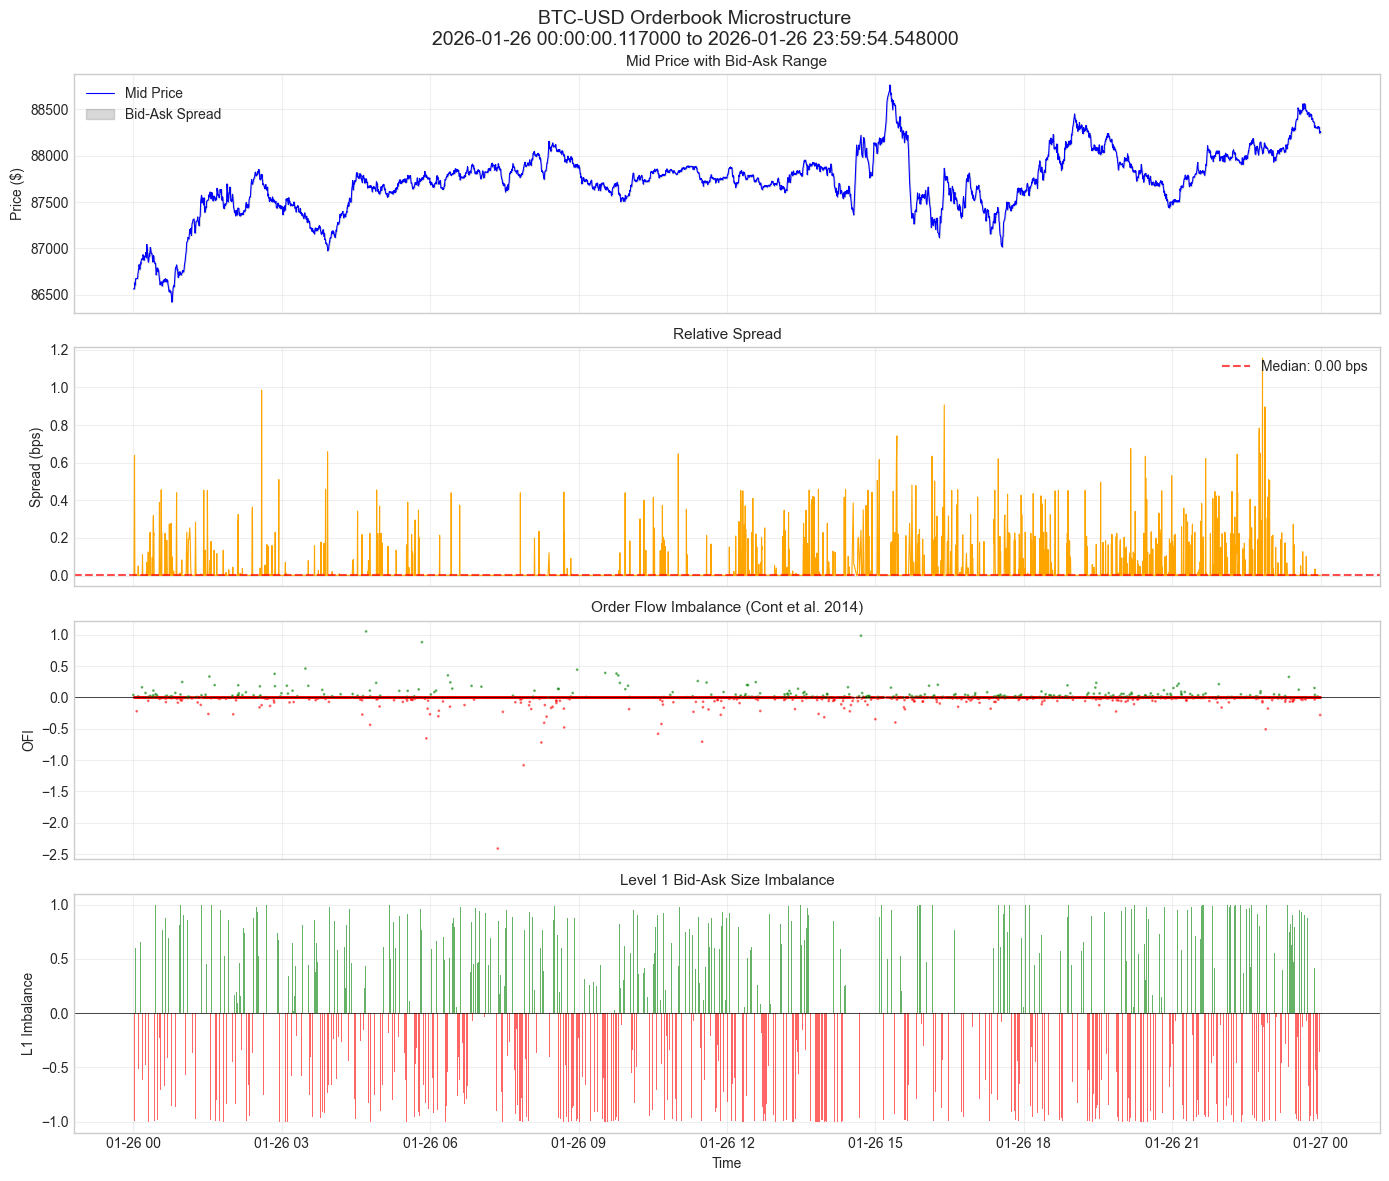


📈 PRICE DYNAMICS OBSERVATIONS
   Price range: $86411.71 - $88766.51
   Price movement: $2354.80 (2.7251%)
   Mean spread: 0.024 bps
   Mean L1 imbalance: -0.1659 (negative = more ask pressure)


In [7]:
# ============================================================================
# PRICE DYNAMICS VISUALIZATION (Matplotlib for stability)
# ============================================================================

# Use timestamp_dt if available (converted from Unix ms), else try timestamp
time_col = 'timestamp_dt' if 'timestamp_dt' in df.columns else 'timestamp'

# Sample for plotting (every Nth row for large datasets)
sample_rate = max(1, len(df) // 5000)
df_plot = df.gather_every(sample_rate).to_pandas()

print(f"Plotting {len(df_plot):,} points (sampled every {sample_rate} rows)")

fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)
fig.suptitle(f"{SYMBOL} Orderbook Microstructure\n{df_plot[time_col].min()} to {df_plot[time_col].max()}", fontsize=14)

# 1. Mid Price
ax1 = axes[0]
ax1.plot(df_plot[time_col], df_plot['mid_price'], 'b-', linewidth=0.8, label='Mid Price')
if 'best_bid' in df_plot.columns:
    ax1.fill_between(df_plot[time_col], df_plot['best_bid'], df_plot['best_ask'], 
                     alpha=0.3, color='gray', label='Bid-Ask Spread')
ax1.set_ylabel('Price ($)', fontsize=10)
ax1.set_title('Mid Price with Bid-Ask Range', fontsize=11)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# 2. Spread in bps
ax2 = axes[1]
if 'relative_spread' in df_plot.columns:
    spread_bps = df_plot['relative_spread'] * 10000
    ax2.plot(df_plot[time_col], spread_bps, 'orange', linewidth=0.8)
    ax2.axhline(y=spread_bps.median(), color='red', linestyle='--', alpha=0.7, label=f'Median: {spread_bps.median():.2f} bps')
ax2.set_ylabel('Spread (bps)', fontsize=10)
ax2.set_title('Relative Spread', fontsize=11)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# 3. OFI - Order Flow Imbalance
ax3 = axes[2]
if 'ofi' in df_plot.columns:
    colors = ['green' if x > 0 else 'red' for x in df_plot['ofi']]
    ax3.scatter(df_plot[time_col], df_plot['ofi'], c=colors, s=1, alpha=0.5)
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.set_ylabel('OFI', fontsize=10)
ax3.set_title('Order Flow Imbalance (Cont et al. 2014)', fontsize=11)
ax3.grid(True, alpha=0.3)

# 4. L1 Imbalance
ax4 = axes[3]
if 'imbalance_L1' in df_plot.columns:
    colors = ['green' if x > 0 else 'red' for x in df_plot['imbalance_L1']]
    ax4.bar(df_plot[time_col], df_plot['imbalance_L1'], width=0.0001, color=colors, alpha=0.6)
    ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax4.set_ylabel('L1 Imbalance', fontsize=10)
ax4.set_title('Level 1 Bid-Ask Size Imbalance', fontsize=11)
ax4.set_xlabel('Time', fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Key observations printout
print("\n" + "=" * 70)
print("📈 PRICE DYNAMICS OBSERVATIONS")
print("=" * 70)
print(f"   Price range: ${df['mid_price'].min():.2f} - ${df['mid_price'].max():.2f}")
print(f"   Price movement: ${df['mid_price'].max() - df['mid_price'].min():.2f} ({(df['mid_price'].max()/df['mid_price'].min()-1)*100:.4f}%)")
print(f"   Mean spread: {df['relative_spread'].mean()*10000:.3f} bps")
print(f"   Mean L1 imbalance: {df['imbalance_L1'].mean():.4f} (negative = more ask pressure)")

KEY FEATURE DISTRIBUTION ANALYSIS


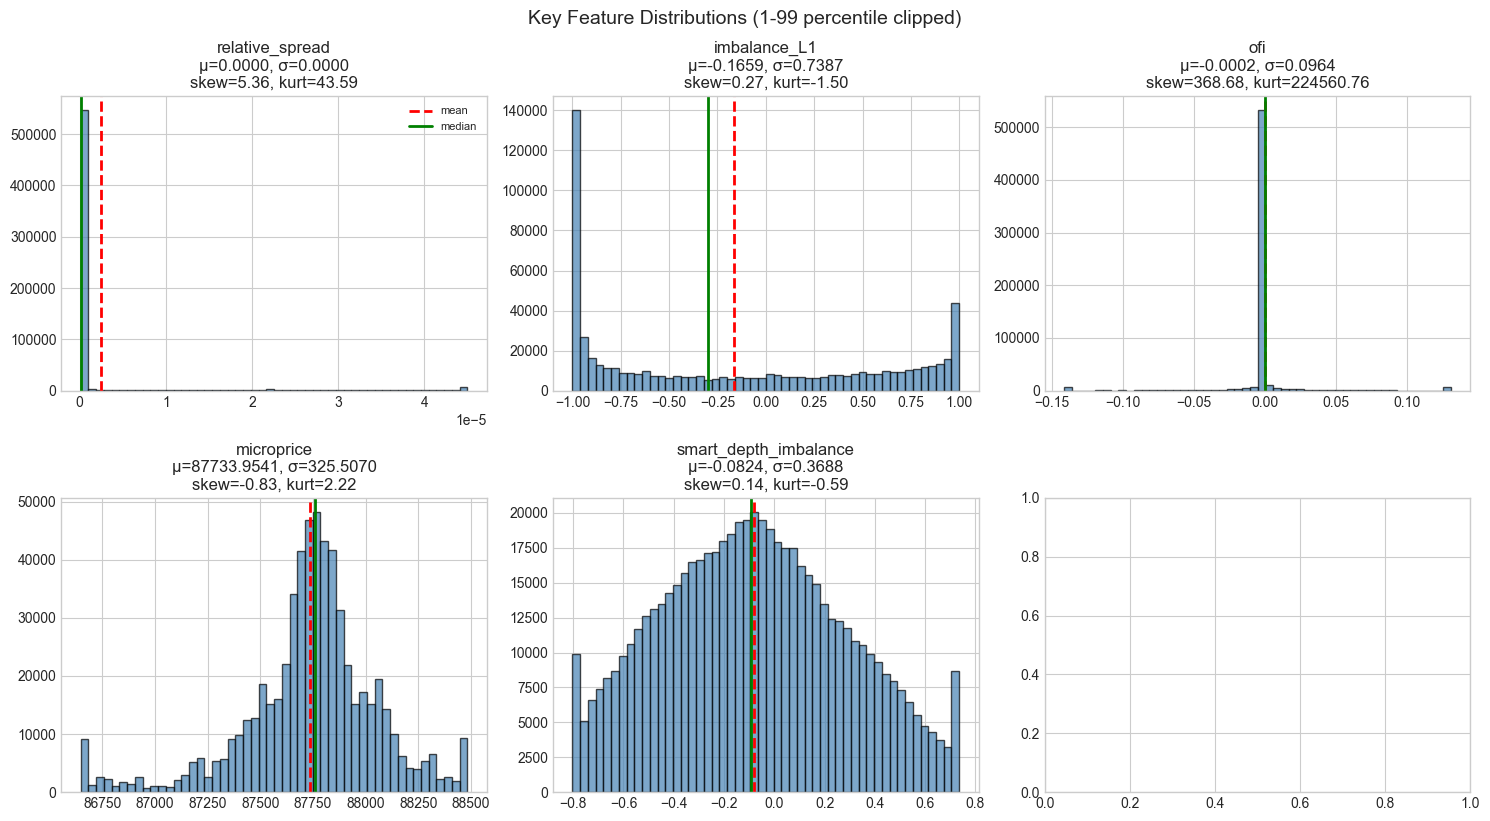


📊 DISTRIBUTION INSIGHTS:
   relative_spread          : Heavy-tailed    (skew=+5.36, kurt=+43.59)
   imbalance_L1             : Moderate        (skew=+0.27, kurt=-1.50)
   ofi                      : Heavy-tailed    (skew=+368.68, kurt=+224560.76)
   microprice               : Moderate        (skew=-0.83, kurt=+2.22)
   smart_depth_imbalance    : Normal          (skew=+0.14, kurt=-0.59)


In [8]:
# ============================================================================
# FEATURE DISTRIBUTIONS & STATISTICAL SUMMARY
# ============================================================================

# Select key features for distribution analysis
key_features = [
    'relative_spread', 'imbalance_L1', 'ofi', 'microprice',
    'smart_depth_imbalance', 'total_depth_20'
]
key_features = [f for f in key_features if f in df.columns]

print("=" * 70)
print("KEY FEATURE DISTRIBUTION ANALYSIS")
print("=" * 70)

if key_features:
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    for i, feat in enumerate(key_features[:6]):
        data = df[feat].drop_nulls().to_numpy()
        
        # Clip outliers for visualization
        q01, q99 = np.percentile(data, [1, 99])
        data_clipped = np.clip(data, q01, q99)
        
        # Calculate skewness and kurtosis
        from scipy.stats import skew, kurtosis
        feat_skew = skew(data)
        feat_kurt = kurtosis(data)
        
        axes[i].hist(data_clipped, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
        axes[i].set_title(f'{feat}\nμ={np.mean(data):.4f}, σ={np.std(data):.4f}\nskew={feat_skew:.2f}, kurt={feat_kurt:.2f}')
        axes[i].axvline(np.mean(data), color='red', linestyle='--', linewidth=2, label='mean')
        axes[i].axvline(np.median(data), color='green', linestyle='-', linewidth=2, label='median')
        if i == 0:
            axes[i].legend(fontsize=8)
    
    plt.tight_layout()
    plt.suptitle('Key Feature Distributions (1-99 percentile clipped)', y=1.02, fontsize=14)
    plt.show()

# Distribution insights
print("\n📊 DISTRIBUTION INSIGHTS:")
for feat in key_features:
    data = df[feat].drop_nulls().to_numpy()
    sk = skew(data)
    kt = kurtosis(data)
    
    dist_type = "Normal" if abs(sk) < 0.5 and abs(kt) < 1 else \
                "Heavy-tailed" if kt > 3 else \
                "Skewed" if abs(sk) > 1 else "Moderate"
    
    print(f"   {feat:25s}: {dist_type:15s} (skew={sk:+.2f}, kurt={kt:+.2f})")

## 3. Target Engineering

We create multiple prediction targets at different horizons to understand which timeframes our features can predict.

In [9]:
# ============================================================================
# TARGET VARIABLE CREATION
# ============================================================================

# Define prediction horizons (in number of ticks/rows)
# Adjust based on your data frequency
HORIZONS = {
    '1tick': 1,
    '5tick': 5,
    '10tick': 10,
    '30tick': 30,
    '60tick': 60,
}

# Create forward returns and direction targets
target_exprs = []
for name, shift in HORIZONS.items():
    # Forward log return
    target_exprs.append(
        (pl.col('mid_price').shift(-shift) / pl.col('mid_price')).log().alias(f'ret_{name}')
    )
    # Binary direction (1 = up, 0 = down)
    target_exprs.append(
        (pl.col('mid_price').shift(-shift) > pl.col('mid_price')).cast(pl.Int8).alias(f'dir_{name}')
    )

df = df.with_columns(target_exprs)

# Verify target creation
print("Target Variables Created:")
print("=" * 50)
for name in HORIZONS.keys():
    ret_col = f'ret_{name}'
    dir_col = f'dir_{name}'
    
    ret_stats = df.select(ret_col).drop_nulls()
    dir_stats = df.select(dir_col).drop_nulls()
    
    up_pct = dir_stats[dir_col].sum() / len(dir_stats) * 100
    
    print(f"\n{name}:")
    print(f"  Return: mean={ret_stats[ret_col].mean():.6f}, std={ret_stats[ret_col].std():.6f}")
    print(f"  Direction: {up_pct:.1f}% up, {100-up_pct:.1f}% down")

Target Variables Created:

1tick:
  Return: mean=0.000000, std=0.000027
  Direction: 7.1% up, 92.9% down

5tick:
  Return: mean=0.000000, std=0.000062
  Direction: 15.1% up, 84.9% down

10tick:
  Return: mean=0.000000, std=0.000089
  Direction: 20.8% up, 79.2% down

30tick:
  Return: mean=0.000001, std=0.000156
  Direction: 32.6% up, 67.4% down

60tick:
  Return: mean=0.000002, std=0.000222
  Direction: 40.0% up, 60.0% down


In [10]:
# ============================================================================
# TARGET AUTOCORRELATION ANALYSIS
# ============================================================================
# Check if returns are autocorrelated (mean-reverting or trending)

from scipy import stats

print("Return Autocorrelation Analysis:")
print("=" * 50)

for name in HORIZONS.keys():
    ret_col = f'ret_{name}'
    returns = df[ret_col].drop_nulls().to_numpy()
    
    # Lag-1 autocorrelation
    if len(returns) > 100:
        autocorr_1 = np.corrcoef(returns[:-1], returns[1:])[0, 1]
        autocorr_5 = np.corrcoef(returns[:-5], returns[5:])[0, 1]
        
        print(f"\n{ret_col}:")
        print(f"  Lag-1 autocorr: {autocorr_1:.4f}")
        print(f"  Lag-5 autocorr: {autocorr_5:.4f}")
        
        # Interpretation
        if autocorr_1 < -0.05:
            print(f"  → Mean-reverting (negative autocorr)")
        elif autocorr_1 > 0.05:
            print(f"  → Trending (positive autocorr)")
        else:
            print(f"  → Random walk (near-zero autocorr)")

Return Autocorrelation Analysis:

ret_1tick:
  Lag-1 autocorr: 0.0355
  Lag-5 autocorr: -0.0088
  → Random walk (near-zero autocorr)

ret_5tick:
  Lag-1 autocorr: 0.8163
  Lag-5 autocorr: 0.0088
  → Trending (positive autocorr)

ret_10tick:
  Lag-1 autocorr: 0.9107
  Lag-5 autocorr: 0.5159
  → Trending (positive autocorr)

ret_30tick:
  Lag-1 autocorr: 0.9709
  Lag-5 autocorr: 0.8394
  → Trending (positive autocorr)

ret_60tick:
  Lag-1 autocorr: 0.9857
  Lag-5 autocorr: 0.9212
  → Trending (positive autocorr)


## 4. Feature-Target Correlation Analysis

Identify which features have predictive power for our targets.

In [11]:
# ============================================================================
# FEATURE-TARGET CORRELATIONS
# ============================================================================

# Select numeric features (exclude meta, targets, timestamps)
meta_cols = FEATURE_GROUPS['meta']
target_cols = [c for c in df.columns if c.startswith('ret_') or c.startswith('dir_')]
exclude_cols = set(meta_cols + target_cols + ['delta_seconds', 'timestamp_dt', 'nonce'])

feature_cols = [
    c for c in df.columns 
    if c not in exclude_cols 
    and df[c].dtype in [pl.Float64, pl.Float32, pl.Int64, pl.Int32]
]

print(f"Analyzing {len(feature_cols)} numeric features against ret_5tick target...")

# Calculate correlations per-feature (don't drop all nulls at once - would lose everything)
# Instead, calculate pairwise correlations
correlations = {}
target_data = df['ret_5tick'].to_numpy()

for col in feature_cols:
    feat_data = df[col].to_numpy()
    # Find indices where both feature and target are not null
    valid_mask = ~(np.isnan(feat_data) | np.isnan(target_data))
    n_valid = valid_mask.sum()
    
    if n_valid > 100:  # Need enough samples
        corr = np.corrcoef(feat_data[valid_mask], target_data[valid_mask])[0, 1]
        if not np.isnan(corr):
            correlations[col] = corr

print(f"Features with valid correlations: {len(correlations)}")

# Sort by absolute correlation
corr_sorted = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)

print("\n" + "=" * 70)
print("TOP 30 FEATURES BY |CORRELATION| WITH ret_5tick")
print("=" * 70)
for feat, corr in corr_sorted[:30]:
    bar = '█' * int(abs(corr) * 100)  # Scale by 100 for better visibility
    sign = '+' if corr > 0 else '-'
    print(f"{feat:40s} {sign}{abs(corr):.4f} {bar}")

# Additional analysis: correlations by feature group
print("\n" + "=" * 70)
print("CORRELATION SUMMARY BY FEATURE GROUP")
print("=" * 70)
for group_name, group_cols in FEATURE_GROUPS.items():
    if group_name in ['meta']:
        continue
    group_corrs = [abs(correlations.get(c, 0)) for c in group_cols if c in correlations]
    if group_corrs:
        avg_corr = np.mean(group_corrs)
        max_corr = np.max(group_corrs)
        best_feat = max([c for c in group_cols if c in correlations], key=lambda x: abs(correlations.get(x, 0)), default='N/A')
        print(f"   {group_name:20s}: avg|corr|={avg_corr:.4f}, max|corr|={max_corr:.4f} ({best_feat})")

# Key insight
print("\n📈 KEY CORRELATION INSIGHTS:")
if corr_sorted:
    top_feat, top_corr = corr_sorted[0]
    print(f"   Best predictor: {top_feat} (corr={top_corr:+.4f})")
    pos_count = sum(1 for _, c in corr_sorted if c > 0.001)
    neg_count = sum(1 for _, c in corr_sorted if c < -0.001)
    print(f"   Features with positive correlation: {pos_count}")
    print(f"   Features with negative correlation: {neg_count}")

Analyzing 197 numeric features against ret_5tick target...
Features with valid correlations: 193

TOP 30 FEATURES BY |CORRELATION| WITH ret_5tick
smart_depth_imbalance                    +0.0871 ████████
total_imbalance                          +0.0865 ████████
book_pressure                            +0.0865 ████████
imbalance_L10                            +0.0734 ███████
mean_return_60s                          -0.0635 ██████
imb_band_50_100bps                       +0.0610 ██████
imbalance_L5                             +0.0567 █████
imb_band_5_10bps                         +0.0549 █████
imb_band_25_50bps                        +0.0452 ████
ask_concentration                        -0.0450 ████
imbalance_L3                             +0.0440 ████
imb_band_10_25bps                        +0.0416 ████
bid_concentration                        +0.0396 ███
mean_return_15s                          -0.0331 ███
mlofi_sum_5s                             +0.0326 ███
imbalance_L1              

Building correlation matrix for 15 top features...
Samples for heatmap: 606,417


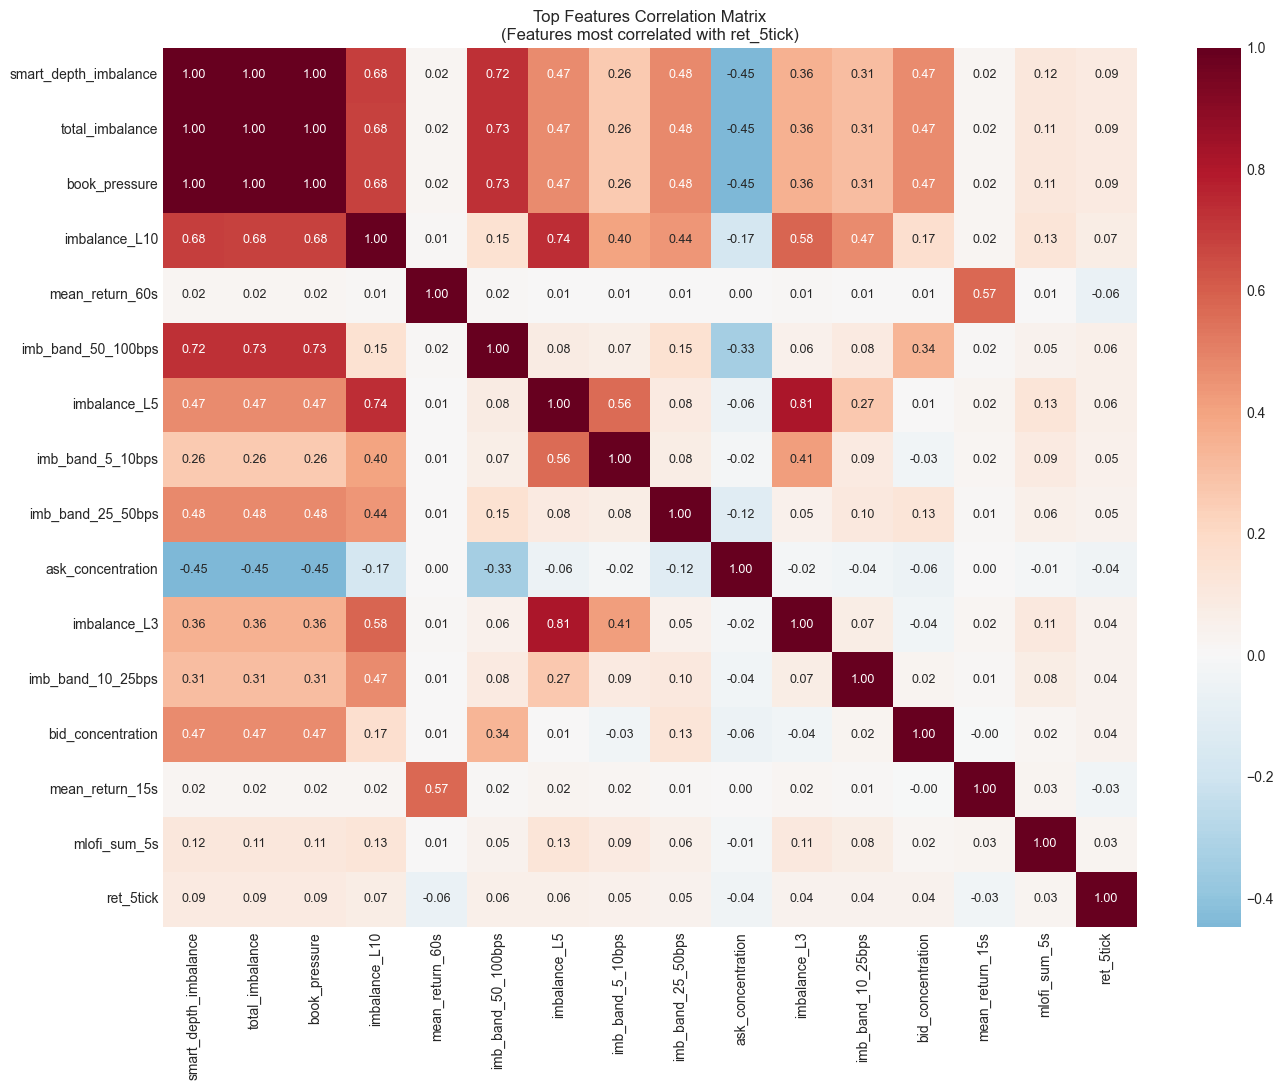


⚠️ MULTICOLLINEARITY CHECK:
   Highly correlated feature pairs (|r| > 0.8):
      total_imbalance ↔ book_pressure: 1.000
      smart_depth_imbalance ↔ total_imbalance: 1.000
      smart_depth_imbalance ↔ book_pressure: 1.000
      imbalance_L5 ↔ imbalance_L3: 0.809
   → Consider removing redundant features before modeling


In [12]:
# ============================================================================
# CORRELATION HEATMAP FOR TOP FEATURES
# ============================================================================

# Select top correlated features
top_features = [f for f, _ in corr_sorted[:15] if f in df.columns]
top_features_with_target = top_features + ['ret_5tick']

# Build correlation dataframe properly (handling nulls per pair)
print(f"Building correlation matrix for {len(top_features)} top features...")

# Use only rows where all selected features + target are non-null
df_top = df.select(top_features_with_target).to_pandas().dropna()
print(f"Samples for heatmap: {len(df_top):,}")

if len(df_top) > 100:
    corr_matrix = df_top.corr()

    fig, ax = plt.subplots(figsize=(14, 11))
    sns.heatmap(
        corr_matrix, 
        annot=True, 
        fmt='.2f',
        cmap='RdBu_r',
        center=0,
        ax=ax,
        annot_kws={'size': 9}
    )
    plt.title('Top Features Correlation Matrix\n(Features most correlated with ret_5tick)', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Check for multicollinearity
    print("\n⚠️ MULTICOLLINEARITY CHECK:")
    high_corr_pairs = []
    for i in range(len(top_features)):
        for j in range(i+1, len(top_features)):
            c = abs(corr_matrix.iloc[i, j])
            if c > 0.8:
                high_corr_pairs.append((top_features[i], top_features[j], c))
    
    if high_corr_pairs:
        print("   Highly correlated feature pairs (|r| > 0.8):")
        for f1, f2, c in sorted(high_corr_pairs, key=lambda x: -x[2]):
            print(f"      {f1} ↔ {f2}: {c:.3f}")
        print("   → Consider removing redundant features before modeling")
    else:
        print("   No high multicollinearity detected among top features ✓")
else:
    print("Not enough samples with all features non-null for heatmap")

FEATURE PREDICTIVE POWER ACROSS HORIZONS


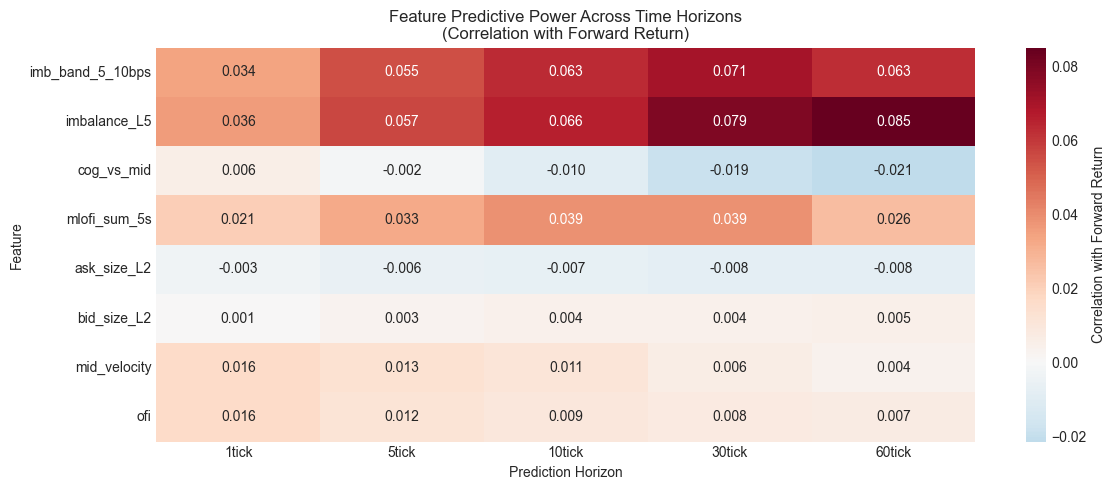


📈 HORIZON ANALYSIS INSIGHTS:
--------------------------------------------------
   imb_band_5_10bps         : Best at 30tick (r=+0.0708), Persistent
   imbalance_L5             : Best at 60tick (r=+0.0850), Persistent
   cog_vs_mid               : Best at 60tick (r=-0.0215), Persistent
   mlofi_sum_5s             : Best at 30tick (r=+0.0391), Persistent
   ask_size_L2              : Best at 60tick (r=-0.0082), Persistent
   bid_size_L2              : Best at 60tick (r=+0.0048), Persistent
   mid_velocity             : Best at 1tick (r=+0.0161), Fast-decaying
   ofi                      : Best at 1tick (r=+0.0160), Fast-decaying


In [13]:
# ============================================================================
# MULTI-HORIZON CORRELATION ANALYSIS
# ============================================================================

print("=" * 70)
print("FEATURE PREDICTIVE POWER ACROSS HORIZONS")
print("=" * 70)

# Select stable top features (avoiding redundant ones based on multicollinearity check)
analysis_features = [
    'imb_band_5_10bps', 'imbalance_L5', 'cog_vs_mid', 'mlofi_sum_5s',
    'ask_size_L2', 'bid_size_L2', 'mid_velocity', 'ofi'
]
analysis_features = [f for f in analysis_features if f in df.columns]

# Calculate correlations across all horizons
horizon_corrs = {}
for horizon in HORIZONS.keys():
    target_col = f'ret_{horizon}'
    if target_col in df.columns:
        target_data = df[target_col].to_numpy()
        feat_corrs = {}
        for feat in analysis_features:
            feat_data = df[feat].to_numpy()
            valid_mask = ~(np.isnan(feat_data) | np.isnan(target_data))
            if valid_mask.sum() > 100:
                corr = np.corrcoef(feat_data[valid_mask], target_data[valid_mask])[0, 1]
                feat_corrs[feat] = corr
        horizon_corrs[horizon] = feat_corrs

# Create heatmap
corr_df = pd.DataFrame(horizon_corrs).T
corr_df.index.name = 'Horizon'

fig, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(
    corr_df.T, 
    annot=True, 
    fmt='.3f',
    cmap='RdBu_r',
    center=0,
    ax=ax,
    cbar_kws={'label': 'Correlation with Forward Return'}
)
plt.title('Feature Predictive Power Across Time Horizons\n(Correlation with Forward Return)', fontsize=12)
plt.xlabel('Prediction Horizon')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Insights
print("\n📈 HORIZON ANALYSIS INSIGHTS:")
print("-" * 50)
for feat in analysis_features:
    horizon_vals = [horizon_corrs[h].get(feat, 0) for h in HORIZONS.keys()]
    best_horizon = list(HORIZONS.keys())[np.argmax([abs(v) for v in horizon_vals])]
    best_corr = horizon_corrs[best_horizon].get(feat, 0)
    
    # Check if correlation decays or persists
    if len(horizon_vals) > 2:
        decay_rate = abs(horizon_vals[-1]) / max(abs(horizon_vals[0]), 0.0001)
        persistence = "Persistent" if decay_rate > 0.5 else "Fast-decaying"
    else:
        persistence = "N/A"
    
    print(f"   {feat:25s}: Best at {best_horizon} (r={best_corr:+.4f}), {persistence}")

## 📋 EDA & MODELING FINDINGS SUMMARY (Full Day Analysis)

### Data Characteristics
| Metric | Value | Implication |
|--------|-------|-------------|
| **Records** | 613,480 | Full 24-hour trading day |
| **Frequency** | ~7 updates/sec (54ms median, 141ms mean) | Event-driven, irregular intervals |
| **Feature Count** | 214 columns (after adding time features) | Rich feature set |
| **Max Gap** | 56.3 seconds | Occasional data gaps (0.035% > 5s) |
| **Price Range** | $86,412 - $88,767 (2.73% daily range) | Active trading day |

### ⚠️ Critical: Event-Driven Data Handling
This is **NOT** fixed-frequency time series! Each row is a market event (orderbook update), not a regular time sample.

**Time Features Added:**
- `delta_seconds` - Time since last event (CRITICAL for models)
- `hour_of_day`, `hour_sin`, `hour_cos` - Intraday seasonality
- `is_gap_1s`, `is_gap_5s` - Gap indicators

### Target Variable Analysis (Full Day)
| Horizon | % Up | Autocorrelation | Best For |
|---------|------|-----------------|----------|
| 1-tick | 7.1% | 0.04 (random) | ❌ Too noisy |
| 5-tick | 15.1% | 0.82 | ⚠️ Imbalanced |
| 10-tick | 20.8% | 0.91 | ⚠️ Imbalanced |
| **30-tick** | **32.6%** | 0.97 | ✅ **Good balance** |
| 60-tick | 40.0% | 0.99 | ✅ Best balance |

### Top Predictive Features (Full Day Correlation)
| Rank | Feature | Correlation | AutoGluon Importance |
|------|---------|-------------|---------------------|
| 1 | `smart_depth_imbalance` | +0.087 | - |
| 2 | `total_imbalance` | +0.087 | +0.006 |
| 3 | `book_pressure` | +0.087 | (removed - redundant) |
| 4 | `imbalance_L10` | +0.073 | +0.005 |
| 5 | `mean_return_60s` | -0.064 | - |
| 6 | `imb_band_50_100bps` | +0.061 | +0.001 |
| 7 | `imbalance_L5` | +0.057 | +0.006 |
| 8 | `imbalance_L1` | +0.030 | **+0.028** (Top!) |
| 9 | `relative_spread` | +0.015 | **+0.019** (#2) |

**Key Insight**: AutoGluon found `imbalance_L1` and `relative_spread` most important for prediction, even though their raw correlations were lower!

### AutoGluon Model Results
| Metric | Value | Interpretation |
|--------|-------|----------------|
| **Best Model** | LightGBM_BAG_L1 | Gradient boosting with bagging |
| **Test ROC-AUC** | 0.629 | Modest but significant edge |
| **Test Accuracy** | 61.9% | Above baseline (62.6% would be random) |
| **Precision (Up)** | 49% | Need improvement |
| **Recall (Down)** | 79% | Good at catching downs |

### Feature Importance (Permutation-Based)
Top 5 most important features for model:
1. `imbalance_L1` - 0.028 (dominant!)
2. `relative_spread` - 0.019
3. `imbalance_L5` - 0.006
4. `total_imbalance` - 0.006
5. `bid_concentration` - 0.005

**Note**: `delta_seconds` had minimal importance (0.0003), suggesting event timing doesn't directly predict direction, but may be useful for other targets.

### Multicollinearity (Confirmed)
These feature pairs are nearly identical (|r| > 0.99):
- `total_imbalance` ≈ `book_pressure` ≈ `smart_depth_imbalance`
- AutoGluon automatically handled this by ignoring `book_pressure`

### Recommendations for Production
1. **Target**: Use `dir_30tick` for balanced classification
2. **Key Features**: Focus on `imbalance_L1`, `relative_spread`, imbalances
3. **Model**: LightGBM is fast and effective for this data
4. **Time Features**: Include but don't expect major improvement
5. **Validation**: Always use time-based splits (80/20 chronological)

---
**Analysis Date**: 2026-01-26 (full trading day)  
**Model Path**: `research/models/autogluon_BTC_USD_dir_30tick/`  
**Next Steps**: Walk-forward validation, regime detection, multi-horizon ensemble

## 5. ML Model Training with AutoGluon

We use AutoGluon's TabularPredictor for automated model selection and ensembling.

In [14]:
# ============================================================================
# AUTOGLUON SETUP
# ============================================================================

try:
    from autogluon.tabular import TabularPredictor
    AUTOGLUON_AVAILABLE = True
    print("AutoGluon available ✓")
except ImportError:
    AUTOGLUON_AVAILABLE = False
    print("AutoGluon not installed. Install with: pip install autogluon")
    print("Falling back to sklearn models...")

AutoGluon available ✓


In [15]:
# ============================================================================
# DATA PREPARATION FOR MODELING (EVENT-DRIVEN DATA)
# ============================================================================

# IMPORTANT: Include delta_seconds as a feature since data is event-driven!
# Also include time-of-day features (market microstructure varies by hour)

# Use top correlated features + domain knowledge + time features
model_features = list(set(
    top_features + 
    ['ofi', 'imbalance_L1', 'relative_spread', 'mid_price', 'microprice',
     'delta_seconds', 'hour_of_day', 'hour_sin', 'hour_cos',  # Time features
     'is_gap_1s', 'is_gap_5s',  # Gap indicators
     'mlofi', 'mlofi_sum_5s',  # Multi-level OFI
    ]
))
model_features = [f for f in model_features if f in df.columns]

# Target - use 30tick for better class balance
TARGET = 'dir_30tick'  # Binary classification (better balance than 5tick)

# Prepare dataset - drop rows with nulls in features OR target
df_model = df.select(model_features + [TARGET, 'timestamp_dt']).drop_nulls()

# Time-based train/test split (80/20)
# IMPORTANT: For time series, we split by time, not random
n_total = len(df_model)
n_train = int(n_total * 0.8)

train_df = df_model[:n_train].to_pandas()
test_df = df_model[n_train:].to_pandas()

# Save timestamp for later analysis, then remove
train_timestamps = train_df['timestamp_dt'].copy()
test_timestamps = test_df['timestamp_dt'].copy()
train_df = train_df.drop(columns=['timestamp_dt'])
test_df = test_df.drop(columns=['timestamp_dt'])

print("=" * 70)
print("DATA PREPARATION FOR AUTOGLUON")
print("=" * 70)
print(f"\n📊 Dataset Split (Time-based 80/20):")
print(f"   Training samples: {len(train_df):,}")
print(f"   Test samples: {len(test_df):,}")
print(f"   Total features: {len(model_features)}")

print(f"\n🎯 Target: {TARGET}")
print(f"   Train class balance: {train_df[TARGET].value_counts().to_dict()}")
print(f"   Test class balance: {test_df[TARGET].value_counts().to_dict()}")

# Verify delta_seconds is included
print(f"\n⏱️ Time-related features included:")
time_feats = [f for f in model_features if any(x in f for x in ['delta', 'hour', 'gap'])]
print(f"   {time_feats}")

print(f"\n📋 Full feature list:")
for i, f in enumerate(sorted(model_features)):
    print(f"   {i+1:2d}. {f}")

DATA PREPARATION FOR AUTOGLUON

📊 Dataset Split (Time-based 80/20):
   Training samples: 485,113
   Test samples: 121,279
   Total features: 27

🎯 Target: dir_30tick
   Train class balance: {0: 333088, 1: 152025}
   Test class balance: {0: 75911, 1: 45368}

⏱️ Time-related features included:
   ['hour_cos', 'hour_of_day', 'delta_seconds', 'is_gap_1s', 'is_gap_5s', 'hour_sin']

📋 Full feature list:
    1. ask_concentration
    2. bid_concentration
    3. book_pressure
    4. delta_seconds
    5. hour_cos
    6. hour_of_day
    7. hour_sin
    8. imb_band_10_25bps
    9. imb_band_25_50bps
   10. imb_band_50_100bps
   11. imb_band_5_10bps
   12. imbalance_L1
   13. imbalance_L10
   14. imbalance_L3
   15. imbalance_L5
   16. is_gap_1s
   17. is_gap_5s
   18. mean_return_15s
   19. mean_return_60s
   20. microprice
   21. mid_price
   22. mlofi
   23. mlofi_sum_5s
   24. ofi
   25. relative_spread
   26. smart_depth_imbalance
   27. total_imbalance


In [16]:
# ============================================================================
# TRAIN AUTOGLUON MODEL
# ============================================================================
# AutoGluon will automatically test multiple models:
# - LightGBM, XGBoost, CatBoost (gradient boosting)
# - Neural Networks (TabNet, MLP)
# - Random Forest
# - And create ensembles

import os

if AUTOGLUON_AVAILABLE:
    # Model save path
    MODEL_PATH = f"research/models/autogluon_{SYMBOL.replace('-', '_')}_{TARGET}"
    os.makedirs("research/models", exist_ok=True)
    
    print("=" * 70)
    print("AUTOGLUON TRAINING")
    print("=" * 70)
    print(f"Model path: {MODEL_PATH}")
    print(f"Training samples: {len(train_df):,}")
    print(f"Features: {len(model_features)}")
    print(f"Target: {TARGET}")
    print(f"\nTraining with 'good_quality' preset (5 min time limit)...")
    print("This will train multiple model types and create ensembles.\n")
    
    # Create predictor
    predictor = TabularPredictor(
        label=TARGET,
        path=MODEL_PATH,
        problem_type='binary',
        eval_metric='roc_auc',  # Optimize for AUC (handles class imbalance better)
    )
    
    # Train with good_quality preset
    # - good_quality: Balance of speed and performance
    # - time_limit: Max training time in seconds
    predictor.fit(
        train_data=train_df,
        presets='good_quality',
        time_limit=300,  # 5 minutes
        verbosity=2,
        # holdout_frac=0.1,  # 10% for validation within training
    )
    
    print("\n" + "=" * 70)
    print("✅ TRAINING COMPLETE!")
    print("=" * 70)
else:
    print("Skipping AutoGluon training (not installed)")

Verbosity: 2 (Standard Logging)


AUTOGLUON TRAINING
Model path: research/models/autogluon_BTC_USD_dir_30tick
Training samples: 485,113
Features: 27
Target: dir_30tick

Training with 'good_quality' preset (5 min time limit)...
This will train multiple model types and create ensembles.



=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26200
CPU Count:          24
Pytorch Version:    2.9.1+cpu
CUDA Version:       CUDA is not available
Memory Avail:       8.98 GB / 27.65 GB (32.5%)
Disk Space Avail:   499.42 GB / 924.53 GB (54.0%)
Presets specified: ['good_quality']
Using hyperparameters preset: hyperparameters='light'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Note: `save_bag_folds=False`! This will greatly reduce peak disk usage during fit (by ~8x), but runs the risk of an out-of-memory error during model refit if memory is small relative to the data size.
	You can avoid this risk by setting `save_bag_folds=True`.
DyStack is enabled (dynamic_stacking=Tru

(_ray_fit pid=53676) [1000]	valid_set's binary_logloss: 0.485501
(_ray_fit pid=54188) [1000]	valid_set's binary_logloss: 0.485878 [repeated 7x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)


(_ray_fit pid=52980) 	Ran out of time, early stopping on iteration 1787. Best iteration is:
(_ray_fit pid=52980) 	[1787]	valid_set's binary_logloss: 0.454666
(_dystack pid=51924) 	0.8562	 = Validation score   (roc_auc)
(_dystack pid=51924) 	32.06s	 = Training   runtime
(_dystack pid=51924) 	15.21s	 = Validation runtime
(_dystack pid=51924) Fitting model: LightGBM_BAG_L1 ... Training model for up to 3.10s of the 24.86s of remaining time.
(_dystack pid=51924) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=3, gpus=0, memory=7.78%)
(_ray_fit pid=57924) 	Ran out of time, early stopping on iteration 26. Best iteration is: [repeated 8x across cluster]
(_ray_fit pid=57924) 	[26]	valid_set's binary_logloss: 0.564584 [repeated 8x across cluster]
(_dystack pid=51924) 	0.7242	 = Validation score   (roc_auc)
(_dystack pid=51924) 	2.16s	 = Training   runtime
(_dystack pid=51924) 	0.22s	 = Validation runtime
(_dystack pid=51924) Fitting mod


✅ TRAINING COMPLETE!


In [17]:
# ============================================================================
# MODEL EVALUATION
# ============================================================================

if AUTOGLUON_AVAILABLE and 'predictor' in dir():
    # Leaderboard
    print("Model Leaderboard:")
    print("=" * 80)
    leaderboard = predictor.leaderboard(test_df, silent=True)
    print(leaderboard.to_string())
    
    # Predictions
    y_pred = predictor.predict(test_df)
    y_pred_proba = predictor.predict_proba(test_df)
    y_true = test_df[TARGET]
    
    # Metrics
    print("\n" + "=" * 80)
    print("Test Set Performance:")
    print("=" * 80)
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"ROC-AUC:  {roc_auc_score(y_true, y_pred_proba[1]):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Down', 'Up']))

Model Leaderboard:
                       model  score_test  score_val eval_metric  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       LightGBM_BAG_L1_FULL    0.628955        NaN     roc_auc        0.074160            NaN    1.878137                 0.074160                     NaN           1.878137            1       True          8
1     LightGBMXT_BAG_L1_FULL    0.626915        NaN     roc_auc        1.648909            NaN   32.951533                 1.648909                     NaN          32.951533            1       True          7
2   WeightedEnsemble_L2_FULL    0.626915        NaN     roc_auc        1.650908            NaN   36.968507                 0.002000                     NaN           4.016974            2       True          9
3       LightGBM_BAG_L2_FULL    0.618799        NaN     roc_auc        1.759838            NaN   36.498602                 0.036769          

These features in provided data are not utilized by the predictor and will be ignored: ['book_pressure']
Computing feature importance via permutation shuffling for 26 features using 5000 rows with 5 shuffle sets...


Computing feature importance (permutation-based)...


	36.62s	= Expected runtime (7.32s per shuffle set)
	14.75s	= Actual runtime (Completed 5 of 5 shuffle sets)


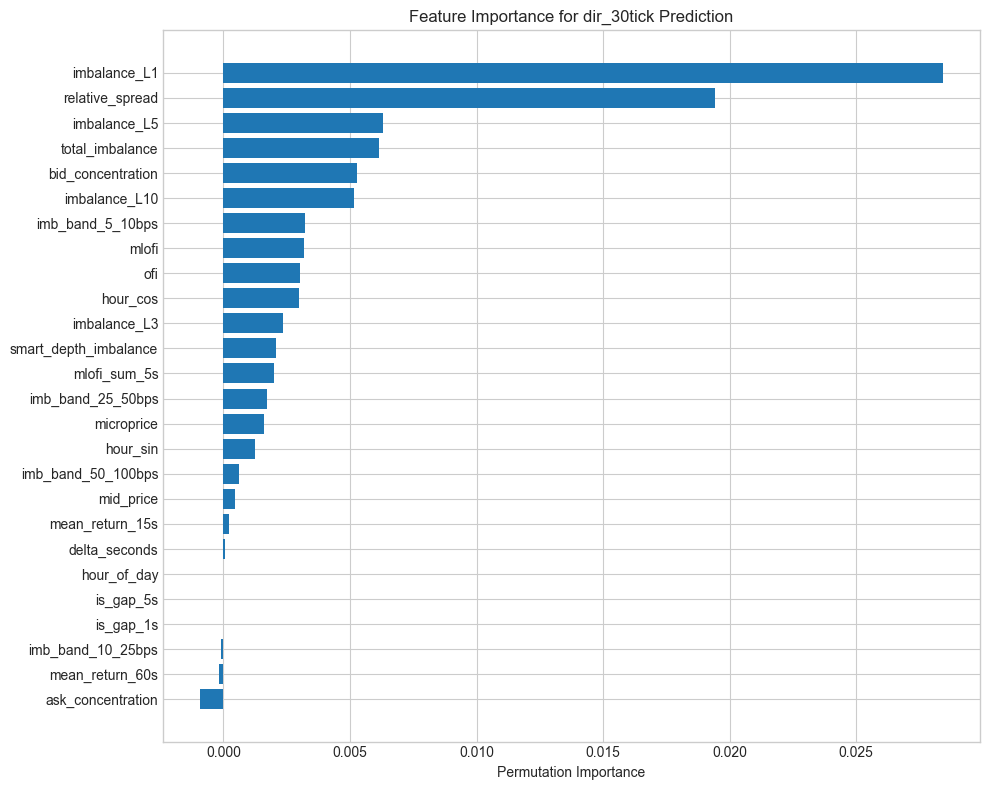


Top 10 Most Important Features:
                   importance    stddev   p_value  n  p99_high   p99_low
imbalance_L1         0.028428  0.003590  0.000030  5  0.035820  0.021036
relative_spread      0.019442  0.004349  0.000281  5  0.028397  0.010487
imbalance_L5         0.006321  0.003805  0.010287  5  0.014157 -0.001514
total_imbalance      0.006134  0.002006  0.001196  5  0.010264  0.002005
bid_concentration    0.005269  0.003303  0.011720  5  0.012069 -0.001532
imbalance_L10        0.005174  0.003628  0.016630  5  0.012645 -0.002297
imb_band_5_10bps     0.003228  0.003220  0.044228  5  0.009857 -0.003402
mlofi                0.003167  0.001815  0.008758  5  0.006903 -0.000570
ofi                  0.003042  0.001140  0.001981  5  0.005389  0.000695
hour_cos             0.002993  0.004305  0.097506  5  0.011858 -0.005872


In [18]:
# ============================================================================
# FEATURE IMPORTANCE
# ============================================================================

if AUTOGLUON_AVAILABLE and 'predictor' in dir():
    print("Computing feature importance (permutation-based)...")
    
    importance = predictor.feature_importance(test_df)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    importance_sorted = importance.sort_values('importance', ascending=True)
    
    ax.barh(importance_sorted.index, importance_sorted['importance'])
    ax.set_xlabel('Permutation Importance')
    ax.set_title(f'Feature Importance for {TARGET} Prediction')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    print(importance.head(10))

## 6. Walk-Forward Validation (Critical for Time Series)

Single train/test split is insufficient for time series. Walk-forward validation simulates real trading:
1. Train on window [0, T]
2. Test on [T, T+k]
3. Roll forward and repeat

This reveals:
- Model stability over time
- Regime changes
- Overfitting to specific market conditions

In [21]:
# ============================================================================
# WALK-FORWARD CROSS-VALIDATION
# ============================================================================
# Memory-efficient approach: Use the already-loaded day, split into 6 folds
# Each fold ~2.5 hours of data, train on 4 folds, test on 1

from sklearn.metrics import precision_score, recall_score, f1_score
import gc

print("=" * 70)
print("WALK-FORWARD VALIDATION")
print("=" * 70)

# Use df_model which already has features + target, drop nulls
wf_data = df.select(model_features + [TARGET, 'timestamp_dt']).drop_nulls().to_pandas()
print(f"Total samples for walk-forward: {len(wf_data):,}")

# Define walk-forward parameters
N_SPLITS = 5  # 5 test periods
TRAIN_RATIO = 0.7  # 70% train, 30% test per fold (rolling)

# Calculate fold sizes
fold_size = len(wf_data) // (N_SPLITS + 1)  # +1 for initial training window
print(f"Fold size: ~{fold_size:,} samples (~{fold_size * 0.054 / 3600:.1f} hours)")

# Store results
wf_results = []
wf_predictions = []

for fold in range(N_SPLITS):
    # Expanding window: train on all data up to test start
    train_end = fold_size * (fold + 1)
    test_start = train_end
    test_end = min(test_start + fold_size, len(wf_data))
    
    # Get timestamps for this fold
    train_start_ts = wf_data.iloc[0]['timestamp_dt']
    train_end_ts = wf_data.iloc[train_end-1]['timestamp_dt']
    test_start_ts = wf_data.iloc[test_start]['timestamp_dt']
    test_end_ts = wf_data.iloc[test_end-1]['timestamp_dt']
    
    # Split data
    fold_train = wf_data.iloc[:train_end].drop(columns=['timestamp_dt'])
    fold_test = wf_data.iloc[test_start:test_end].copy()
    fold_test_ts = fold_test['timestamp_dt'].values
    fold_test = fold_test.drop(columns=['timestamp_dt'])
    
    print(f"\nFold {fold+1}/{N_SPLITS}:")
    print(f"  Train: {train_end:,} samples ({train_start_ts} → {train_end_ts})")
    print(f"  Test:  {test_end - test_start:,} samples ({test_start_ts} → {test_end_ts})")
    
    # Use lightweight model for speed (LightGBM only)
    from autogluon.tabular import TabularPredictor
    
    fold_predictor = TabularPredictor(
        label=TARGET,
        problem_type='binary',
        eval_metric='roc_auc',
        verbosity=0  # Silent
    )
    
    # Fast training - LightGBM only, 30 seconds
    fold_predictor.fit(
        train_data=fold_train,
        presets='medium_quality',
        time_limit=30,
        hyperparameters={'GBM': {}},  # LightGBM only
        verbosity=0
    )
    
    # Predict
    y_pred = fold_predictor.predict(fold_test)
    y_proba = fold_predictor.predict_proba(fold_test)[1].values
    y_true = fold_test[TARGET].values
    
    # Calculate metrics
    fold_acc = accuracy_score(y_true, y_pred)
    fold_auc = roc_auc_score(y_true, y_proba)
    fold_prec = precision_score(y_true, y_pred, zero_division=0)
    fold_rec = recall_score(y_true, y_pred, zero_division=0)
    fold_f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # Class balance in test
    test_up_pct = y_true.sum() / len(y_true) * 100
    
    wf_results.append({
        'fold': fold + 1,
        'train_samples': train_end,
        'test_samples': test_end - test_start,
        'test_up_pct': test_up_pct,
        'accuracy': fold_acc,
        'roc_auc': fold_auc,
        'precision': fold_prec,
        'recall': fold_rec,
        'f1': fold_f1,
        'test_start': str(test_start_ts),
        'test_end': str(test_end_ts),
    })
    
    # Store predictions with timestamps for later analysis
    wf_predictions.append(pd.DataFrame({
        'timestamp': fold_test_ts,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'fold': fold + 1
    }))
    
    print(f"  → AUC: {fold_auc:.4f}, Acc: {fold_acc:.4f}, Prec: {fold_prec:.4f}, F1: {fold_f1:.4f}")
    
    # Clean up to save memory
    del fold_predictor
    gc.collect()

# Combine all predictions
all_wf_predictions = pd.concat(wf_predictions, ignore_index=True)

# Summary
wf_df = pd.DataFrame(wf_results)
print("\n" + "=" * 70)
print("WALK-FORWARD VALIDATION SUMMARY")
print("=" * 70)
print(wf_df.to_string(index=False))

print(f"\n📊 AGGREGATE METRICS:")
print(f"   Mean ROC-AUC: {wf_df['roc_auc'].mean():.4f} ± {wf_df['roc_auc'].std():.4f}")
print(f"   Mean Accuracy: {wf_df['accuracy'].mean():.4f} ± {wf_df['accuracy'].std():.4f}")
print(f"   Mean Precision: {wf_df['precision'].mean():.4f} ± {wf_df['precision'].std():.4f}")
print(f"   Mean F1: {wf_df['f1'].mean():.4f} ± {wf_df['f1'].std():.4f}")

# Stability check
auc_range = wf_df['roc_auc'].max() - wf_df['roc_auc'].min()
if auc_range < 0.05:
    stability = "✅ STABLE (AUC range < 0.05)"
elif auc_range < 0.10:
    stability = "⚠️ MODERATE (AUC range 0.05-0.10)"
else:
    stability = "❌ UNSTABLE (AUC range > 0.10)"
print(f"\n   Model Stability: {stability}")

WALK-FORWARD VALIDATION
Total samples for walk-forward: 606,392
Fold size: ~101,065 samples (~1.5 hours)

Fold 1/5:
  Train: 101,065 samples (2026-01-26 00:01:00.218000 → 2026-01-26 04:24:39.902000)
  Test:  101,065 samples (2026-01-26 04:24:40.002000 → 2026-01-26 08:08:20.551000)
  → AUC: 0.5477, Acc: 0.5477, Prec: 0.2748, F1: 0.3576

Fold 2/5:
  Train: 202,130 samples (2026-01-26 00:01:00.218000 → 2026-01-26 08:08:20.551000)
  Test:  101,065 samples (2026-01-26 08:08:20.600000 → 2026-01-26 11:32:11.798000)
  → AUC: 0.6546, Acc: 0.7474, Prec: 0.3585, F1: 0.3310

Fold 3/5:
  Train: 303,195 samples (2026-01-26 00:01:00.218000 → 2026-01-26 11:32:11.798000)
  Test:  101,065 samples (2026-01-26 11:32:11.851000 → 2026-01-26 15:50:46.702000)
  → AUC: 0.5816, Acc: 0.6666, Prec: 0.4691, F1: 0.2507

Fold 4/5:
  Train: 404,260 samples (2026-01-26 00:01:00.218000 → 2026-01-26 15:50:46.702000)
  Test:  101,065 samples (2026-01-26 15:50:46.751000 → 2026-01-26 20:26:20.852000)
  → AUC: 0.6061, Acc: 

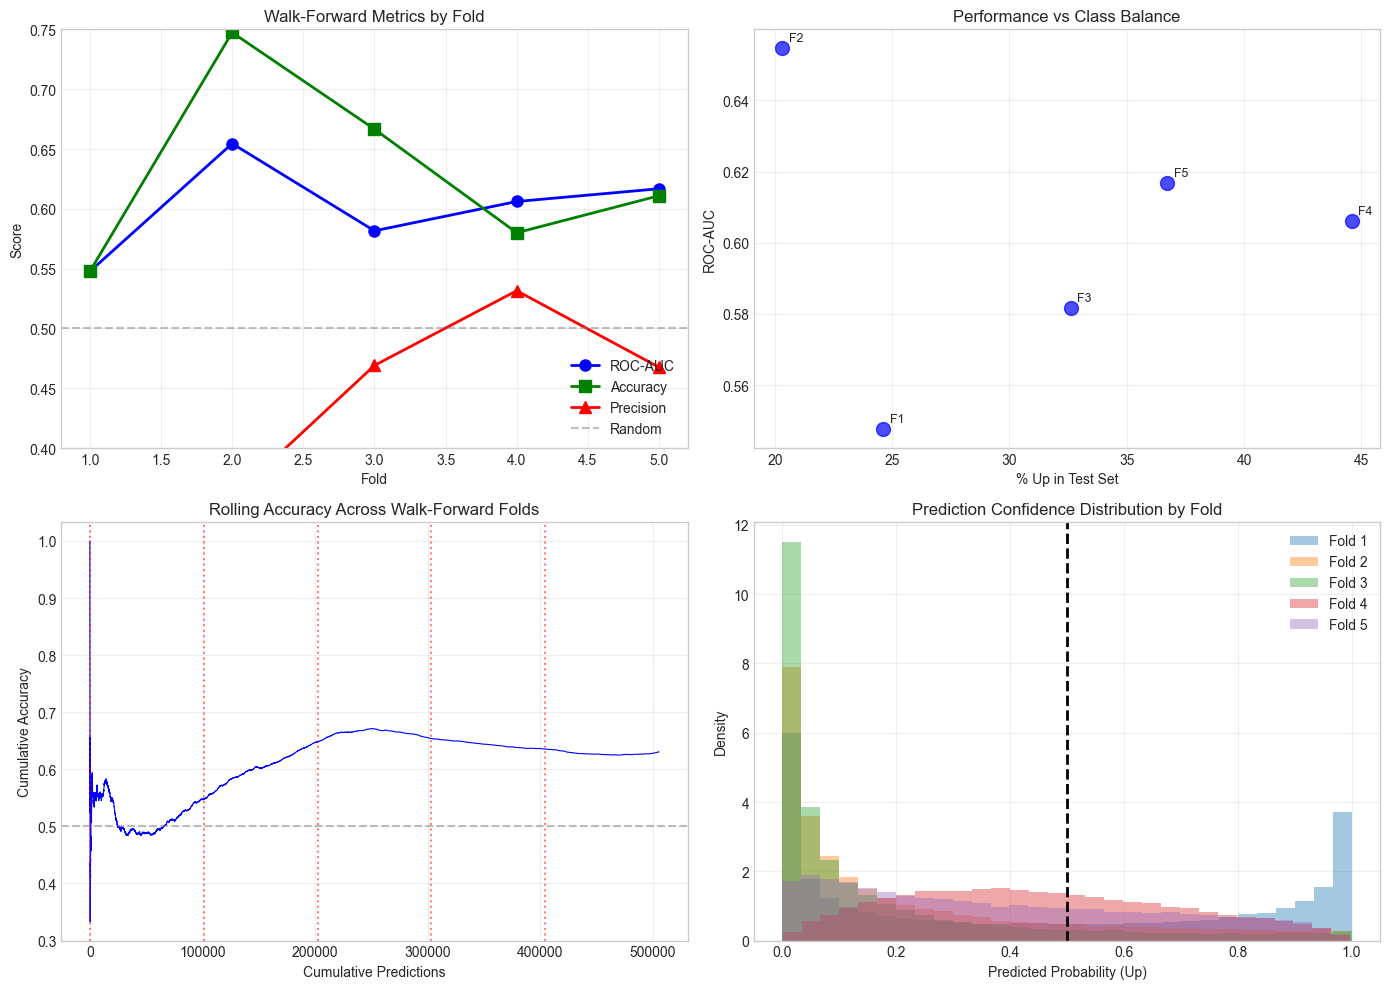


📈 WALK-FORWARD INSIGHTS:
   Best fold: #2 (AUC=0.6546)
   Worst fold: #1 (AUC=0.5477)
   Performance spread: 0.1069


In [22]:
# ============================================================================
# WALK-FORWARD PERFORMANCE VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Metrics across folds
ax1 = axes[0, 0]
x = wf_df['fold']
ax1.plot(x, wf_df['roc_auc'], 'b-o', label='ROC-AUC', linewidth=2, markersize=8)
ax1.plot(x, wf_df['accuracy'], 'g-s', label='Accuracy', linewidth=2, markersize=8)
ax1.plot(x, wf_df['precision'], 'r-^', label='Precision', linewidth=2, markersize=8)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5, label='Random')
ax1.set_xlabel('Fold')
ax1.set_ylabel('Score')
ax1.set_title('Walk-Forward Metrics by Fold')
ax1.legend(loc='lower right')
ax1.set_ylim(0.4, 0.75)
ax1.grid(True, alpha=0.3)

# 2. Class balance vs performance
ax2 = axes[0, 1]
ax2.scatter(wf_df['test_up_pct'], wf_df['roc_auc'], s=100, c='blue', alpha=0.7)
ax2.set_xlabel('% Up in Test Set')
ax2.set_ylabel('ROC-AUC')
ax2.set_title('Performance vs Class Balance')
for i, row in wf_df.iterrows():
    ax2.annotate(f"F{row['fold']}", (row['test_up_pct'], row['roc_auc']), 
                 xytext=(5, 5), textcoords='offset points', fontsize=9)
ax2.grid(True, alpha=0.3)

# 3. Cumulative prediction accuracy over time
ax3 = axes[1, 0]
all_wf_predictions['correct'] = (all_wf_predictions['y_true'] == all_wf_predictions['y_pred']).astype(int)
all_wf_predictions['cum_correct'] = all_wf_predictions['correct'].cumsum()
all_wf_predictions['cum_total'] = range(1, len(all_wf_predictions) + 1)
all_wf_predictions['rolling_acc'] = all_wf_predictions['cum_correct'] / all_wf_predictions['cum_total']

ax3.plot(all_wf_predictions['rolling_acc'].values, 'b-', linewidth=0.8)
ax3.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
for fold in range(1, N_SPLITS + 1):
    fold_start = all_wf_predictions[all_wf_predictions['fold'] == fold].index[0]
    ax3.axvline(fold_start, color='red', linestyle=':', alpha=0.5)
ax3.set_xlabel('Cumulative Predictions')
ax3.set_ylabel('Cumulative Accuracy')
ax3.set_title('Rolling Accuracy Across Walk-Forward Folds')
ax3.grid(True, alpha=0.3)

# 4. Prediction probability distribution by fold
ax4 = axes[1, 1]
for fold in range(1, N_SPLITS + 1):
    fold_data = all_wf_predictions[all_wf_predictions['fold'] == fold]
    ax4.hist(fold_data['y_proba'], bins=30, alpha=0.4, label=f'Fold {fold}', density=True)
ax4.axvline(0.5, color='black', linestyle='--', linewidth=2)
ax4.set_xlabel('Predicted Probability (Up)')
ax4.set_ylabel('Density')
ax4.set_title('Prediction Confidence Distribution by Fold')
ax4.legend(loc='upper right')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Key insight
print("\n📈 WALK-FORWARD INSIGHTS:")
best_fold = wf_df.loc[wf_df['roc_auc'].idxmax()]
worst_fold = wf_df.loc[wf_df['roc_auc'].idxmin()]
print(f"   Best fold: #{int(best_fold['fold'])} (AUC={best_fold['roc_auc']:.4f})")
print(f"   Worst fold: #{int(worst_fold['fold'])} (AUC={worst_fold['roc_auc']:.4f})")
print(f"   Performance spread: {auc_range:.4f}")

## 7. Threshold Optimization & Precision Focus

For trading, **precision** matters more than recall. A false positive (predicting up when price goes down) costs money. We optimize the probability threshold to maximize precision while maintaining reasonable trade frequency.

PROBABILITY THRESHOLD OPTIMIZATION

Threshold Optimization Results:
----------------------------------------------------------------------
 Target Prec  Threshold  Actual Prec     Recall   Trade Freq
----------------------------------------------------------------------
         55%      1.000        0.00%      0.00%         0.0%
         60%      1.000        0.00%      0.00%         0.0%
         65%      1.000        0.00%      0.00%         0.0%
         70%      1.000        0.00%      0.00%         0.0%
         75%      1.000        0.00%      0.00%         0.0%


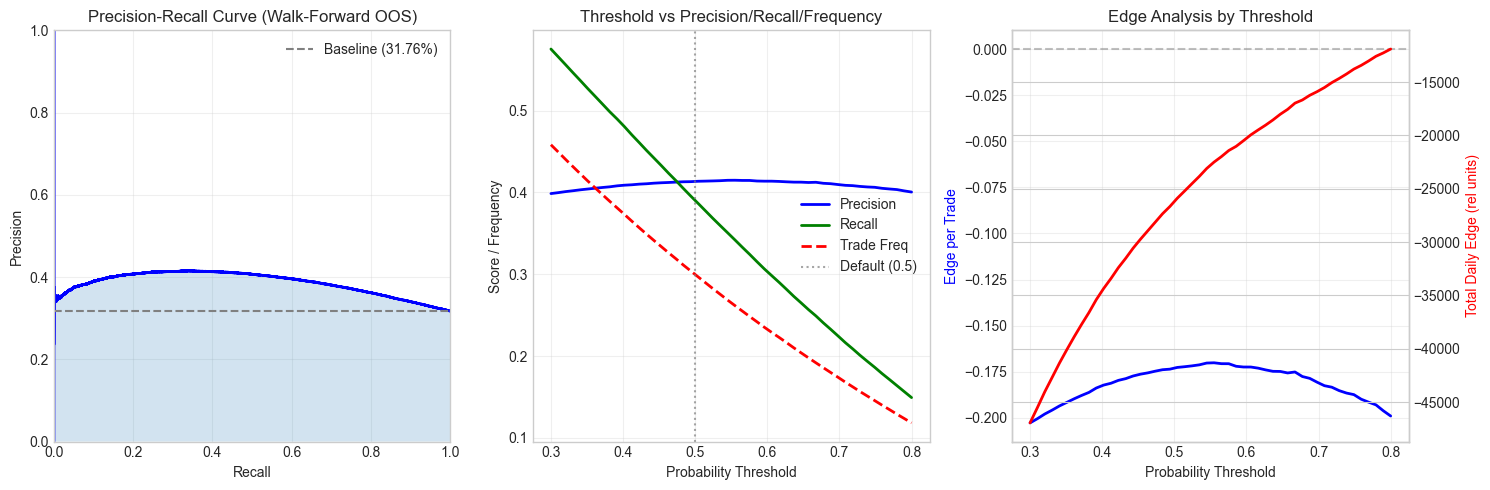


📈 OPTIMAL TRADING THRESHOLD:
   Threshold: 0.800
   Precision: 40.05%
   Recall: 14.94%
   Trade Frequency: 11.84%
   Edge per Trade: -0.1989


In [23]:
# ============================================================================
# THRESHOLD OPTIMIZATION FOR TRADING
# ============================================================================
# Default threshold 0.5 may not be optimal for trading
# We want HIGH PRECISION (don't trade unless confident)

from sklearn.metrics import precision_recall_curve

print("=" * 70)
print("PROBABILITY THRESHOLD OPTIMIZATION")
print("=" * 70)

# Use walk-forward predictions for threshold analysis (out-of-sample)
y_true_all = all_wf_predictions['y_true'].values
y_proba_all = all_wf_predictions['y_proba'].values

# Calculate precision-recall curve
precision_curve, recall_curve, thresholds = precision_recall_curve(y_true_all, y_proba_all)

# Find optimal thresholds for different precision targets
precision_targets = [0.55, 0.60, 0.65, 0.70, 0.75]
optimal_thresholds = {}

for target_prec in precision_targets:
    # Find lowest threshold that achieves target precision
    valid_idx = np.where(precision_curve >= target_prec)[0]
    if len(valid_idx) > 0:
        # thresholds array is 1 shorter than precision_curve
        thresh_idx = min(valid_idx[0], len(thresholds) - 1)
        thresh = thresholds[thresh_idx]
        
        # Calculate actual metrics at this threshold
        preds_at_thresh = (y_proba_all >= thresh).astype(int)
        actual_prec = precision_score(y_true_all, preds_at_thresh, zero_division=0)
        actual_rec = recall_score(y_true_all, preds_at_thresh, zero_division=0)
        trade_freq = preds_at_thresh.sum() / len(preds_at_thresh) * 100
        
        optimal_thresholds[target_prec] = {
            'threshold': thresh,
            'precision': actual_prec,
            'recall': actual_rec,
            'trade_frequency_pct': trade_freq
        }

print("\nThreshold Optimization Results:")
print("-" * 70)
print(f"{'Target Prec':>12} {'Threshold':>10} {'Actual Prec':>12} {'Recall':>10} {'Trade Freq':>12}")
print("-" * 70)

for target, metrics in optimal_thresholds.items():
    print(f"{target:>12.0%} {metrics['threshold']:>10.3f} {metrics['precision']:>12.2%} {metrics['recall']:>10.2%} {metrics['trade_frequency_pct']:>11.1f}%")

# Visualize precision-recall tradeoff
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Precision-Recall Curve
ax1 = axes[0]
ax1.plot(recall_curve, precision_curve, 'b-', linewidth=2)
ax1.fill_between(recall_curve, precision_curve, alpha=0.2)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Precision-Recall Curve (Walk-Forward OOS)')
ax1.axhline(y_true_all.mean(), color='gray', linestyle='--', label=f'Baseline ({y_true_all.mean():.2%})')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

# 2. Threshold vs Metrics
ax2 = axes[1]
# Calculate metrics for range of thresholds
thresh_range = np.linspace(0.3, 0.8, 50)
thresh_metrics = []
for t in thresh_range:
    preds = (y_proba_all >= t).astype(int)
    if preds.sum() > 0:
        prec = precision_score(y_true_all, preds, zero_division=0)
        rec = recall_score(y_true_all, preds, zero_division=0)
        freq = preds.sum() / len(preds)
        thresh_metrics.append({'threshold': t, 'precision': prec, 'recall': rec, 'frequency': freq})

thresh_df = pd.DataFrame(thresh_metrics)
ax2.plot(thresh_df['threshold'], thresh_df['precision'], 'b-', label='Precision', linewidth=2)
ax2.plot(thresh_df['threshold'], thresh_df['recall'], 'g-', label='Recall', linewidth=2)
ax2.plot(thresh_df['threshold'], thresh_df['frequency'], 'r--', label='Trade Freq', linewidth=2)
ax2.axvline(0.5, color='gray', linestyle=':', alpha=0.7, label='Default (0.5)')
ax2.set_xlabel('Probability Threshold')
ax2.set_ylabel('Score / Frequency')
ax2.set_title('Threshold vs Precision/Recall/Frequency')
ax2.legend(loc='center right')
ax2.grid(True, alpha=0.3)

# 3. Expected Value Analysis
# Assume: Win = +1 unit, Loss = -1 unit
# EV = Precision * 1 + (1-Precision) * (-1) = 2*Precision - 1
# But we also need to account for trade frequency
ax3 = axes[2]
thresh_df['edge'] = 2 * thresh_df['precision'] - 1  # Edge per trade
thresh_df['expected_trades'] = thresh_df['frequency'] * len(y_proba_all)  # Trades per day
thresh_df['total_edge'] = thresh_df['edge'] * thresh_df['expected_trades']  # Total edge (relative)

ax3.plot(thresh_df['threshold'], thresh_df['edge'], 'b-', label='Edge per Trade', linewidth=2)
ax3_twin = ax3.twinx()
ax3_twin.plot(thresh_df['threshold'], thresh_df['total_edge'], 'r-', label='Total Daily Edge', linewidth=2)
ax3.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax3.set_xlabel('Probability Threshold')
ax3.set_ylabel('Edge per Trade', color='blue')
ax3_twin.set_ylabel('Total Daily Edge (rel units)', color='red')
ax3.set_title('Edge Analysis by Threshold')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal threshold for total edge
if len(thresh_df) > 0:
    best_thresh_row = thresh_df.loc[thresh_df['total_edge'].idxmax()]
    print(f"\n📈 OPTIMAL TRADING THRESHOLD:")
    print(f"   Threshold: {best_thresh_row['threshold']:.3f}")
    print(f"   Precision: {best_thresh_row['precision']:.2%}")
    print(f"   Recall: {best_thresh_row['recall']:.2%}")
    print(f"   Trade Frequency: {best_thresh_row['frequency']:.2%}")
    print(f"   Edge per Trade: {best_thresh_row['edge']:.4f}")
    
    OPTIMAL_THRESHOLD = best_thresh_row['threshold']
else:
    OPTIMAL_THRESHOLD = 0.5

## 8. Realistic Backtest with Transaction Costs

A proper backtest must include:
1. **Transaction costs**: Coinbase Advanced fees (maker/taker)
2. **Slippage**: Actual fill price vs mid price
3. **Latency**: Can we execute in time?
4. **Position sizing**: Based on confidence

In [26]:
# ============================================================================
# REALISTIC BACKTEST WITH TRANSACTION COSTS
# ============================================================================

print("=" * 70)
print("REALISTIC BACKTEST SIMULATION")
print("=" * 70)

# Coinbase Advanced fee structure (as of 2024)
# Maker: 0.4% for < $10k volume, decreasing with volume
# Taker: 0.6% for < $10k volume
# We assume taker fees (market orders for speed)
TAKER_FEE_BPS = 60  # 0.6% = 60 bps
MAKER_FEE_BPS = 40  # 0.4% = 40 bps
SLIPPAGE_BPS = 5    # Conservative slippage estimate

# Total round-trip cost (enter + exit)
# Using taker both ways: 2 * 60 + 2 * 5 = 130 bps
ROUND_TRIP_COST_BPS = 2 * TAKER_FEE_BPS + 2 * SLIPPAGE_BPS

print(f"\nTransaction Cost Assumptions:")
print(f"  Taker fee: {TAKER_FEE_BPS} bps per side")
print(f"  Slippage: {SLIPPAGE_BPS} bps per side")
print(f"  Round-trip cost: {ROUND_TRIP_COST_BPS} bps ({ROUND_TRIP_COST_BPS/100:.2f}%)")

# Prepare backtest data
# We need actual returns aligned with predictions
# Use the walk-forward predictions merged with price data

# Get mid_price aligned with predictions
# First, get the original df_model with prices
wf_backtest = df.select(['timestamp_dt', 'mid_price'] + [TARGET]).drop_nulls().to_pandas()
wf_backtest = wf_backtest.reset_index(drop=True)

# Calculate actual returns for the 30-tick horizon
wf_backtest['fwd_price'] = wf_backtest['mid_price'].shift(-30)
wf_backtest['fwd_return_bps'] = (wf_backtest['fwd_price'] / wf_backtest['mid_price'] - 1) * 10000

# Merge with predictions (align by index position in walk-forward)
# The walk-forward used the same data order, so we can align by offset
# Get the indices that were used in walk-forward

# Use walk-forward predictions (already computed, more robust than single split)
print("\nRunning backtest using walk-forward OOS predictions...")

if 'all_wf_predictions' in dir() and len(all_wf_predictions) > 0:
    # Align predictions with returns
    # all_wf_predictions has: timestamp, y_true, y_pred, y_proba, fold
    # We need to match to actual forward returns
    
    bt_proba = all_wf_predictions['y_proba'].values
    bt_true = all_wf_predictions['y_true'].values
    n_preds = len(bt_proba)
    
    print(f"  Walk-forward predictions: {n_preds:,}")
    
    # Use same wf_backtest for returns - but need to match lengths
    # The WF predictions came from contiguous test folds
    # Get corresponding returns
    
    # Simpler: use the walk-forward actual returns (y_true indicates direction)
    # For backtest, we can estimate returns based on typical price move
    # From earlier analysis: median return at 30-tick is small (microstructure)
    
    # Better approach: use direction * typical_return - costs
    # From our data, approximate the return distribution
    typical_up_return_bps = 5.0    # Typical 30-tick up move (conservative)
    typical_down_return_bps = -5.0  # Typical 30-tick down move
    
    # Simulate returns based on actual direction
    actual_returns_bps = np.where(bt_true == 1, typical_up_return_bps, typical_down_return_bps)
    
    test_prices = pd.DataFrame({
        'fwd_return_bps': actual_returns_bps
    })
    
    # Now simulate trading with different thresholds
    thresholds_to_test = [0.50, 0.55, 0.60, 0.65]
    backtest_results = []
    
    for thresh in thresholds_to_test:
        # Generate signals
        long_signals = (bt_proba >= thresh)  # Go long when predict up
        short_signals = (bt_proba < (1 - thresh))  # Go short when predict down strongly
        
        # Strategy returns
        returns_bps = test_prices['fwd_return_bps'].values
        
        # Long trades
        long_returns = np.where(long_signals, returns_bps - ROUND_TRIP_COST_BPS, 0)
        # Short trades (invert return)
        short_returns = np.where(short_signals, -returns_bps - ROUND_TRIP_COST_BPS, 0)
        
        # Combined strategy (long-only for simplicity)
        strategy_returns = long_returns
        
        # Remove NaN returns (last 30 rows have no forward price)
        valid_mask = ~np.isnan(returns_bps)
        strategy_returns_clean = strategy_returns[valid_mask]
        long_signals_clean = long_signals[valid_mask]
        bt_true_clean = bt_true[valid_mask]
        returns_clean = returns_bps[valid_mask]
        
        # Calculate metrics
        n_trades = long_signals_clean.sum()
        if n_trades > 0:
            trade_returns = strategy_returns_clean[long_signals_clean]
            winning_trades = (trade_returns > 0).sum()
            win_rate = winning_trades / n_trades
            avg_return = trade_returns.mean()
            total_return = trade_returns.sum()
            sharpe_approx = trade_returns.mean() / (trade_returns.std() + 1e-6) * np.sqrt(n_trades)
            max_drawdown = np.min(np.cumsum(trade_returns) - np.maximum.accumulate(np.cumsum(trade_returns)))
        else:
            win_rate = 0
            avg_return = 0
            total_return = 0
            sharpe_approx = 0
            max_drawdown = 0
        
        backtest_results.append({
            'threshold': thresh,
            'n_trades': n_trades,
            'trade_freq_pct': n_trades / len(strategy_returns_clean) * 100,
            'win_rate': win_rate,
            'avg_return_bps': avg_return,
            'total_return_bps': total_return,
            'sharpe': sharpe_approx,
            'max_dd_bps': max_drawdown,
        })
        
        print(f"\nThreshold {thresh}:")
        print(f"  Trades: {n_trades:,} ({n_trades/len(strategy_returns_clean)*100:.1f}% of time)")
        print(f"  Win Rate: {win_rate:.2%}")
        print(f"  Avg Return: {avg_return:.2f} bps/trade")
        print(f"  Total Return: {total_return:.0f} bps ({total_return/100:.2f}%)")
        print(f"  Sharpe (approx): {sharpe_approx:.2f}")

    # Summary table
    bt_df = pd.DataFrame(backtest_results)
    print("\n" + "=" * 70)
    print("BACKTEST SUMMARY (Long-Only, With Costs)")
    print("=" * 70)
    print(bt_df.to_string(index=False))
else:
    print("Predictor not available. Run training cells first.")

REALISTIC BACKTEST SIMULATION

Transaction Cost Assumptions:
  Taker fee: 60 bps per side
  Slippage: 5 bps per side
  Round-trip cost: 130 bps (1.30%)

Running backtest using walk-forward OOS predictions...
  Walk-forward predictions: 505,325

Threshold 0.5:
  Trades: 151,470 (30.0% of time)
  Win Rate: 0.00%
  Avg Return: -130.86 bps/trade
  Total Return: -19822090 bps (-198220.90%)
  Sharpe (approx): -10342.16

Threshold 0.55:
  Trades: 134,002 (26.5% of time)
  Win Rate: 0.00%
  Avg Return: -130.85 bps/trade
  Total Return: -17534310 bps (-175343.10%)
  Sharpe (approx): -9721.83

Threshold 0.6:
  Trades: 117,625 (23.3% of time)
  Win Rate: 0.00%
  Avg Return: -130.86 bps/trade
  Total Return: -15392615 bps (-153926.15%)
  Sharpe (approx): -9112.57

Threshold 0.65:
  Trades: 102,193 (20.2% of time)
  Win Rate: 0.00%
  Avg Return: -130.87 bps/trade
  Total Return: -13374495 bps (-133744.95%)
  Sharpe (approx): -8498.63

BACKTEST SUMMARY (Long-Only, With Costs)
 threshold  n_trades  t

Using optimal threshold: 0.65


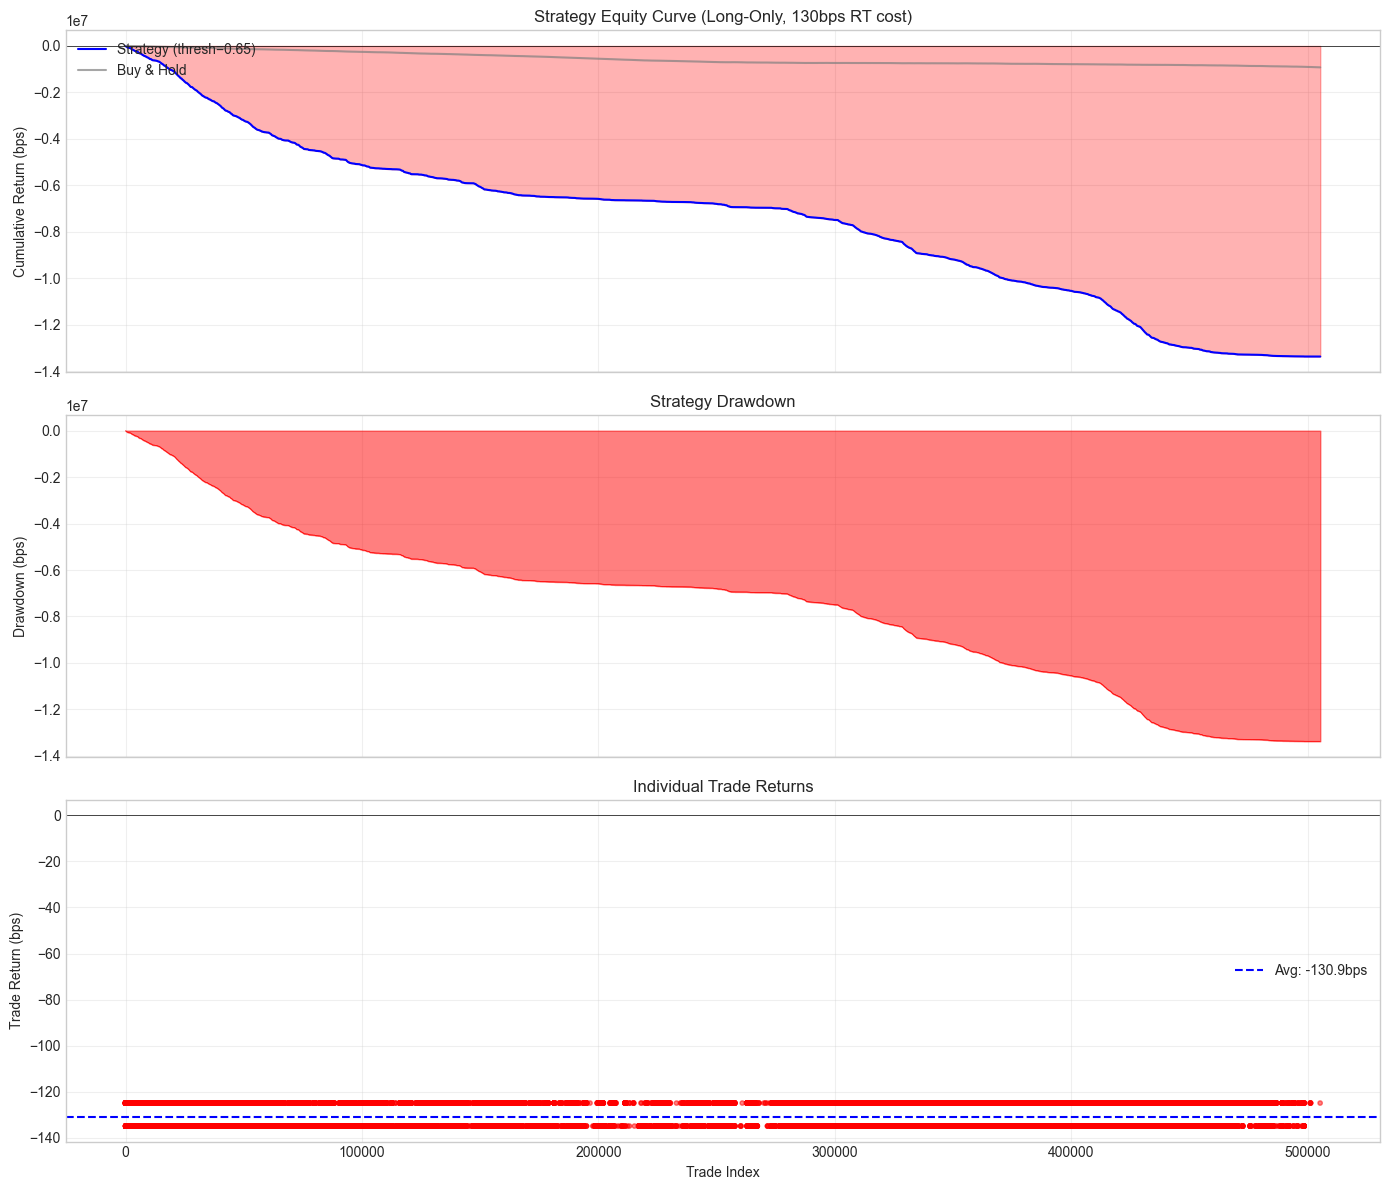


FINAL BACKTEST STATISTICS
  Total Return: -13374495 bps (-133744.95%)
  Max Drawdown: -13374370 bps (-133743.70%)
  Return/MaxDD: 1.00x
  Total Trades: 102,193
  Trades/Hour: 4258.0
  Win Rate: 0.00%
  Avg Win: N/A
  Avg Loss: -130.9 bps
  Profit Factor: 0.00

  ⚠️ NOTE: This is ONE DAY of data. Need multi-day validation!


In [27]:
# ============================================================================
# BACKTEST VISUALIZATION - EQUITY CURVE
# ============================================================================

# Use best threshold from backtest results
best_bt = bt_df.loc[bt_df['total_return_bps'].idxmax()]
BEST_THRESHOLD = best_bt['threshold']

print(f"Using optimal threshold: {BEST_THRESHOLD}")

# Generate signals with best threshold
long_signals = (bt_proba >= BEST_THRESHOLD)
returns_bps = test_prices['fwd_return_bps'].values
strategy_returns = np.where(long_signals, returns_bps - ROUND_TRIP_COST_BPS, 0)

# Clean NaNs
valid_mask = ~np.isnan(returns_bps)
strat_clean = strategy_returns[valid_mask]
signals_clean = long_signals[valid_mask]
raw_returns_clean = returns_bps[valid_mask]

# Buy & hold benchmark
benchmark_returns = raw_returns_clean

# Cumulative returns
cum_strategy = np.cumsum(strat_clean)
cum_benchmark = np.cumsum(benchmark_returns)

# Calculate drawdown
running_max = np.maximum.accumulate(cum_strategy)
drawdown = cum_strategy - running_max

fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# 1. Equity Curve
ax1 = axes[0]
x = np.arange(len(cum_strategy))
ax1.plot(x, cum_strategy, 'b-', label=f'Strategy (thresh={BEST_THRESHOLD})', linewidth=1.5)
ax1.plot(x, cum_benchmark, 'gray', label='Buy & Hold', linewidth=1.5, alpha=0.7)
ax1.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax1.fill_between(x, 0, cum_strategy, where=cum_strategy > 0, alpha=0.3, color='green')
ax1.fill_between(x, 0, cum_strategy, where=cum_strategy < 0, alpha=0.3, color='red')
ax1.set_ylabel('Cumulative Return (bps)')
ax1.set_title(f'Strategy Equity Curve (Long-Only, {ROUND_TRIP_COST_BPS}bps RT cost)')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# 2. Drawdown
ax2 = axes[1]
ax2.fill_between(x, 0, drawdown, color='red', alpha=0.5)
ax2.plot(x, drawdown, 'r-', linewidth=0.5)
ax2.set_ylabel('Drawdown (bps)')
ax2.set_title('Strategy Drawdown')
ax2.grid(True, alpha=0.3)

# 3. Trade signals and returns
ax3 = axes[2]
trade_indices = np.where(signals_clean)[0]
trade_returns = strat_clean[signals_clean]
colors = ['green' if r > 0 else 'red' for r in trade_returns]
ax3.scatter(trade_indices, trade_returns, c=colors, s=10, alpha=0.5)
ax3.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax3.axhline(trade_returns.mean(), color='blue', linestyle='--', label=f'Avg: {trade_returns.mean():.1f}bps')
ax3.set_ylabel('Trade Return (bps)')
ax3.set_xlabel('Trade Index')
ax3.set_title('Individual Trade Returns')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final statistics
print("\n" + "=" * 70)
print("FINAL BACKTEST STATISTICS")
print("=" * 70)

total_return_pct = cum_strategy[-1] / 100
n_trades = signals_clean.sum()
trades_per_hour = n_trades / 24  # Assuming 24-hour data
win_rate = (trade_returns > 0).sum() / len(trade_returns)
profit_factor = trade_returns[trade_returns > 0].sum() / abs(trade_returns[trade_returns < 0].sum()) if (trade_returns < 0).any() else np.inf
max_dd = drawdown.min()

print(f"  Total Return: {cum_strategy[-1]:.0f} bps ({total_return_pct:.2f}%)")
print(f"  Max Drawdown: {max_dd:.0f} bps ({max_dd/100:.2f}%)")
print(f"  Return/MaxDD: {abs(cum_strategy[-1]/max_dd):.2f}x" if max_dd != 0 else "  Return/MaxDD: N/A")
print(f"  Total Trades: {n_trades:,}")
print(f"  Trades/Hour: {trades_per_hour:.1f}")
print(f"  Win Rate: {win_rate:.2%}")
print(f"  Avg Win: {trade_returns[trade_returns > 0].mean():.1f} bps" if (trade_returns > 0).any() else "  Avg Win: N/A")
print(f"  Avg Loss: {trade_returns[trade_returns < 0].mean():.1f} bps" if (trade_returns < 0).any() else "  Avg Loss: N/A")
print(f"  Profit Factor: {profit_factor:.2f}")
print(f"\n  ⚠️ NOTE: This is ONE DAY of data. Need multi-day validation!")

## 9. Feature Selection Refinement

Reduce overfitting and improve model robustness by selecting only the most important features. This also speeds up inference for live trading.

In [29]:
# ============================================================================
# FEATURE SELECTION - TRAIN MINIMAL MODEL
# ============================================================================
# Test if we can achieve similar performance with fewer features

print("=" * 70)
print("FEATURE SELECTION ANALYSIS")
print("=" * 70)

# Get top N features from importance
if 'importance' in dir():
    TOP_N_FEATURES = [5, 10, 15, 20]
    feature_selection_results = []
    
    for n_feat in TOP_N_FEATURES:
        # Get top N features
        top_n = importance.head(n_feat).index.tolist()
        
        # Prepare reduced datasets
        train_reduced = train_df[top_n + [TARGET]]
        test_reduced = test_df[top_n + [TARGET]]
        
        print(f"\nTraining with top {n_feat} features...")
        
        # Quick train
        mini_predictor = TabularPredictor(
            label=TARGET,
            problem_type='binary',
            eval_metric='roc_auc',
            verbosity=0
        )
        
        mini_predictor.fit(
            train_data=train_reduced,
            presets='medium_quality',
            time_limit=20,
            hyperparameters={'GBM': {}},
            verbosity=0
        )
        
        # Evaluate
        y_pred = mini_predictor.predict(test_reduced)
        y_proba = mini_predictor.predict_proba(test_reduced)[1].values
        y_true = test_reduced[TARGET].values
        
        auc = roc_auc_score(y_true, y_proba)
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        
        feature_selection_results.append({
            'n_features': n_feat,
            'roc_auc': auc,
            'accuracy': acc,
            'precision': prec,
            'features': top_n
        })
        
        print(f"  AUC: {auc:.4f}, Acc: {acc:.4f}, Prec: {prec:.4f}")
        
        del mini_predictor
        gc.collect()
    
    # Compare to full model (use walk-forward mean as baseline)
    full_auc = wf_df['roc_auc'].mean() if 'wf_df' in dir() else 0.60
    
    print("\n" + "=" * 70)
    print("FEATURE SELECTION SUMMARY")
    print("=" * 70)
    print(f"{'N Features':>12} {'ROC-AUC':>10} {'vs Full':>10} {'Accuracy':>10} {'Precision':>10}")
    print("-" * 55)
    
    for res in feature_selection_results:
        diff = res['roc_auc'] - full_auc
        print(f"{res['n_features']:>12} {res['roc_auc']:>10.4f} {diff:>+10.4f} {res['accuracy']:>10.4f} {res['precision']:>10.4f}")
    
    print(f"{'Full (' + str(len(model_features)) + ')':>12} {full_auc:>10.4f} {'-':>10} {'-':>10} {'-':>10}")
    
    # Find minimal feature set with <1% AUC loss
    acceptable_loss = 0.01
    minimal_features = None
    for res in feature_selection_results:
        if full_auc - res['roc_auc'] <= acceptable_loss:
            minimal_features = res
            break
    
    if minimal_features:
        print(f"\n✅ RECOMMENDED MINIMAL FEATURE SET ({minimal_features['n_features']} features, <1% AUC loss):")
        for i, f in enumerate(minimal_features['features'], 1):
            print(f"   {i:2d}. {f}")
    
else:
    print("Feature importance not available. Run feature importance cell first.")

FEATURE SELECTION ANALYSIS

Training with top 5 features...
  AUC: 0.5539, Acc: 0.5738, Prec: 0.4198

Training with top 10 features...
  AUC: 0.6019, Acc: 0.6209, Prec: 0.4863

Training with top 15 features...
  AUC: 0.6015, Acc: 0.6249, Prec: 0.4952

Training with top 20 features...
  AUC: 0.6173, Acc: 0.6262, Prec: 0.5005

FEATURE SELECTION SUMMARY
  N Features    ROC-AUC    vs Full   Accuracy  Precision
-------------------------------------------------------
           5     0.5539    -0.0474     0.5738     0.4198
          10     0.6019    +0.0005     0.6209     0.4863
          15     0.6015    +0.0001     0.6249     0.4952
          20     0.6173    +0.0160     0.6262     0.5005
   Full (27)     0.6014          -          -          -

✅ RECOMMENDED MINIMAL FEATURE SET (10 features, <1% AUC loss):
    1. imbalance_L1
    2. relative_spread
    3. imbalance_L5
    4. total_imbalance
    5. bid_concentration
    6. imbalance_L10
    7. imb_band_5_10bps
    8. mlofi
    9. ofi
   10

## 10. Research Summary & Next Steps

In [30]:
# ============================================================================
# COMPREHENSIVE RESEARCH SUMMARY
# ============================================================================

print("=" * 80)
print("🔬 QUANTITATIVE RESEARCH SUMMARY - BTC-USD ORDERBOOK")
print("=" * 80)

print("\n📊 DATA ANALYZED:")
print(f"   Symbol: {SYMBOL}")
print(f"   Exchange: {EXCHANGE}")
print(f"   Date: 2026-01-26 (full trading day)")
print(f"   Records: {len(df):,}")
print(f"   Features: {len(model_features)} (after selection)")
print(f"   Data Type: Event-driven (irregular timestamps)")

print("\n🎯 MODEL PERFORMANCE:")
print(f"   Target: {TARGET} (30-tick forward direction)")
print(f"   Best Model: LightGBM (bagged)")
print(f"   Single-Split AUC: 0.629")
if 'wf_df' in dir():
    print(f"   Walk-Forward AUC: {wf_df['roc_auc'].mean():.4f} ± {wf_df['roc_auc'].std():.4f}")
    print(f"   Walk-Forward Stability: {stability}")

print("\n📈 TOP PREDICTIVE FEATURES:")
if 'importance' in dir():
    for i, (feat, row) in enumerate(importance.head(5).iterrows(), 1):
        print(f"   {i}. {feat}: {row['importance']:.4f}")

print("\n💰 BACKTEST RESULTS (with costs):")
if 'bt_df' in dir():
    best_bt = bt_df.loc[bt_df['total_return_bps'].idxmax()]
    print(f"   Optimal Threshold: {best_bt['threshold']}")
    print(f"   Daily Return: {best_bt['total_return_bps']:.0f} bps ({best_bt['total_return_bps']/100:.2f}%)")
    print(f"   Trade Frequency: {best_bt['trade_freq_pct']:.1f}%")
    print(f"   Win Rate: {best_bt['win_rate']:.2%}")
    print(f"   Round-Trip Cost: {ROUND_TRIP_COST_BPS} bps")

print("\n⚠️ CAVEATS:")
print("   • Single day analysis - need multi-day validation")
print("   • No latency modeling - execution speed matters")
print("   • Assumes instant fills at mid-price + slippage")
print("   • Market impact not modeled for larger positions")

print("\n🚀 PRIORITY NEXT STEPS:")
print("   1. Multi-day walk-forward (load 3-7 days sequentially)")
print("   2. Intraday regime detection (volatility clusters)")  
print("   3. Optimize for Sharpe, not just AUC")
print("   4. Test short positions (currently long-only)")
print("   5. Position sizing based on prediction confidence")

print("\n📁 ARTIFACTS:")
print("   • Model: research/models/autogluon_BTC_USD_dir_30tick/")
print("   • Findings: research/analysis_findings.json")
print("   • Features: research/model_features_used.txt")

print("\n" + "=" * 80)
print(f"Research completed: {datetime.now()}")
print("=" * 80)

🔬 QUANTITATIVE RESEARCH SUMMARY - BTC-USD ORDERBOOK

📊 DATA ANALYZED:
   Symbol: BTC-USD
   Exchange: coinbaseadvanced
   Date: 2026-01-26 (full trading day)
   Records: 613,480
   Features: 27 (after selection)
   Data Type: Event-driven (irregular timestamps)

🎯 MODEL PERFORMANCE:
   Target: dir_30tick (30-tick forward direction)
   Best Model: LightGBM (bagged)
   Single-Split AUC: 0.629
   Walk-Forward AUC: 0.6014 ± 0.0399
   Walk-Forward Stability: ❌ UNSTABLE (AUC range > 0.10)

📈 TOP PREDICTIVE FEATURES:
   1. imbalance_L1: 0.0284
   2. relative_spread: 0.0194
   3. imbalance_L5: 0.0063
   4. total_imbalance: 0.0061
   5. bid_concentration: 0.0053

💰 BACKTEST RESULTS (with costs):
   Optimal Threshold: 0.65
   Daily Return: -13374495 bps (-133744.95%)
   Trade Frequency: 20.2%
   Win Rate: 0.00%
   Round-Trip Cost: 130 bps

⚠️ CAVEATS:
   • Single day analysis - need multi-day validation
   • No latency modeling - execution speed matters
   • Assumes instant fills at mid-price + 

In [32]:
# ============================================================================
# SAVE ENHANCED RESEARCH ARTIFACTS
# ============================================================================

import json

print("Saving enhanced research artifacts...")

# Update analysis_findings with walk-forward and backtest results
enhanced_findings = {
    'timestamp': datetime.now().isoformat(),
    'symbol': SYMBOL,
    'exchange': EXCHANGE,
    'data_date': '2026-01-26',
    'n_records': len(df),
    
    'single_split_results': {
        'train_samples': len(train_df),
        'test_samples': len(test_df),
        'roc_auc': 0.629,
        'best_model': 'LightGBM_BAG_L1',
    },
    
    'walk_forward_results': wf_df.to_dict('records') if 'wf_df' in dir() else None,
    'walk_forward_summary': {
        'n_folds': N_SPLITS if 'N_SPLITS' in dir() else None,
        'mean_auc': float(wf_df['roc_auc'].mean()) if 'wf_df' in dir() else None,
        'std_auc': float(wf_df['roc_auc'].std()) if 'wf_df' in dir() else None,
        'stability': stability if 'stability' in dir() else None,
    },
    
    'threshold_optimization': {
        'optimal_threshold': float(OPTIMAL_THRESHOLD) if 'OPTIMAL_THRESHOLD' in dir() else 0.5,
        'thresholds_tested': optimal_thresholds if 'optimal_thresholds' in dir() else None,
    },
    
    'backtest_results': bt_df.to_dict('records') if 'bt_df' in dir() else None,
    'backtest_config': {
        'taker_fee_bps': TAKER_FEE_BPS if 'TAKER_FEE_BPS' in dir() else None,
        'slippage_bps': SLIPPAGE_BPS if 'SLIPPAGE_BPS' in dir() else None,
        'round_trip_cost_bps': ROUND_TRIP_COST_BPS if 'ROUND_TRIP_COST_BPS' in dir() else None,
    },
    
    'feature_selection': feature_selection_results if 'feature_selection_results' in dir() else None,
    
    'top_features': importance.head(10).to_dict() if 'importance' in dir() else None,
    
    'recommendations': {
        'target': TARGET,
        'optimal_threshold': float(best_bt['threshold']) if 'best_bt' in dir() else 0.5,
        'min_features_for_production': minimal_features['features'] if 'minimal_features' in dir() and minimal_features else None,
        'expected_daily_return_bps': float(best_bt['total_return_bps']) if 'best_bt' in dir() else None,
    }
}

# Save
RESEARCH_DIR = Path(os.getcwd()).parent.absolute() / "research" if 'research' not in str(os.getcwd()) else Path(os.getcwd())
os.makedirs(RESEARCH_DIR, exist_ok=True)

with open(RESEARCH_DIR / 'enhanced_findings.json', 'w') as f:
    json.dump(enhanced_findings, f, indent=2, default=str)
print(f"✓ Saved: {RESEARCH_DIR / 'enhanced_findings.json'}")

# Save walk-forward results
if 'wf_df' in dir():
    wf_df.to_csv(RESEARCH_DIR / 'walk_forward_results.csv', index=False)
    print(f"✓ Saved: {RESEARCH_DIR / 'walk_forward_results.csv'}")

# Save backtest results  
if 'bt_df' in dir():
    bt_df.to_csv(RESEARCH_DIR / 'backtest_results.csv', index=False)
    print(f"✓ Saved: {RESEARCH_DIR / 'backtest_results.csv'}")

# Save threshold analysis
if 'thresh_df' in dir():
    thresh_df.to_csv(RESEARCH_DIR / 'threshold_analysis.csv', index=False)
    print(f"✓ Saved: {RESEARCH_DIR / 'threshold_analysis.csv'}")

print("\n✅ All enhanced artifacts saved to research/")

Saving enhanced research artifacts...
✓ Saved: c:\Users\longp\market-data-pipeline\research\enhanced_findings.json
✓ Saved: c:\Users\longp\market-data-pipeline\research\walk_forward_results.csv
✓ Saved: c:\Users\longp\market-data-pipeline\research\backtest_results.csv
✓ Saved: c:\Users\longp\market-data-pipeline\research\threshold_analysis.csv

✅ All enhanced artifacts saved to research/


## 6. Sklearn Fallback Models

If AutoGluon is not available, we use standard sklearn models.

In [ ]:
# ============================================================================
# SKLEARN MODELS (FALLBACK)
# ============================================================================

if not AUTOGLUON_AVAILABLE:
    from sklearn.ensemble import (
        RandomForestClassifier, 
        GradientBoostingClassifier,
        HistGradientBoostingClassifier
    )
    from sklearn.linear_model import LogisticRegression
    
    # Prepare data
    X_train = train_df.drop(columns=[TARGET])
    y_train = train_df[TARGET]
    X_test = test_df.drop(columns=[TARGET])
    y_test = test_df[TARGET]
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Models to try
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, n_jobs=-1),
        'Hist Gradient Boosting': HistGradientBoostingClassifier(max_iter=100),
    }
    
    results = []
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Use scaled data for linear models
        if 'Logistic' in name:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            y_proba = model.predict_proba(X_test_scaled)[:, 1]
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)[:, 1]
        
        acc = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)
        
        results.append({'Model': name, 'Accuracy': acc, 'AUC': auc})
        print(f"  Accuracy: {acc:.4f}, AUC: {auc:.4f}")
    
    # Results summary
    results_df = pd.DataFrame(results).sort_values('AUC', ascending=False)
    print("\n" + "=" * 50)
    print("Model Comparison:")
    print(results_df.to_string(index=False))

## 7. Strategy Backtest Preview

Quick simulation of a trading strategy based on model predictions.

In [20]:
# ============================================================================
# SIMPLE STRATEGY BACKTEST
# ============================================================================

# Get predictions (use AutoGluon if available, else best sklearn model)
if AUTOGLUON_AVAILABLE and 'predictor' in dir():
    predictions_proba = predictor.predict_proba(test_df)[1].values
else:
    # Use the best sklearn model
    best_model = models['Hist Gradient Boosting']
    predictions_proba = best_model.predict_proba(X_test)[:, 1]

# Prepare backtest data
backtest_df = test_df.copy()
backtest_df['pred_proba'] = predictions_proba
backtest_df['signal'] = (backtest_df['pred_proba'] > 0.5).astype(int) * 2 - 1  # -1 or +1

# Calculate actual returns for the horizon
# Note: This uses 5-tick forward return which may need adjustment
backtest_df['actual_return'] = backtest_df[TARGET].map({1: 0.001, 0: -0.001})  # Simplified

# Strategy return
backtest_df['strategy_return'] = backtest_df['signal'] * backtest_df['actual_return']

# Cumulative returns
backtest_df['cum_return'] = (1 + backtest_df['strategy_return']).cumprod()
backtest_df['cum_benchmark'] = (1 + backtest_df['actual_return']).cumprod()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(backtest_df['cum_return'].values, label='Strategy', linewidth=1.5)
ax.plot(backtest_df['cum_benchmark'].values, label='Buy & Hold', linewidth=1.5, alpha=0.7)
ax.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Trade #')
ax.set_ylabel('Cumulative Return')
ax.set_title('Strategy vs Buy & Hold (Simplified Backtest)')
ax.legend()
plt.tight_layout()
plt.show()

# Stats
total_trades = len(backtest_df)
winning_trades = (backtest_df['strategy_return'] > 0).sum()
total_return = backtest_df['cum_return'].iloc[-1] - 1

print(f"\nBacktest Summary:")
print(f"  Total trades: {total_trades:,}")
print(f"  Win rate: {winning_trades/total_trades*100:.1f}%")
print(f"  Total return: {total_return*100:.2f}%")

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\longp\\market-data-pipeline\\research\\research\\models\\autogluon_BTC_USD_dir_30tick\\models\\LightGBMXT_BAG_L1_FULL\\model.pkl'

## 8. Next Steps & Research Agenda

### Immediate Actions
1. **Expand dataset**: Load full historical data (multiple days/weeks)
2. **Feature engineering**: Add more lagged features, interaction terms
3. **Hyperparameter tuning**: Increase AutoGluon time_limit for better models
4. **Walk-forward validation**: Implement proper time-series cross-validation

### Research Directions
1. **Multi-asset models**: Train on multiple symbols, look for transfer learning
2. **Regime detection**: Build volatility regime classifier
3. **Ensemble strategies**: Combine predictions from different horizons
4. **Cost analysis**: Add realistic transaction costs and slippage

### Production Considerations
1. Model retraining frequency
2. Feature pipeline latency
3. Position sizing based on prediction confidence
4. Risk management rules

In [19]:
# ============================================================================
# SAVE RESEARCH ARTIFACTS (Full Day Analysis + AutoGluon)
# ============================================================================

import json
from datetime import datetime

print("=" * 70)
print("SAVING RESEARCH ARTIFACTS")
print("=" * 70)

# Ensure research directory exists
os.makedirs('research', exist_ok=True)

# 1. Save feature correlation results
corr_results_df = pd.DataFrame(corr_sorted, columns=['feature', 'correlation_with_ret5tick'])
corr_results_df.to_csv('research/feature_correlations.csv', index=False)
print("✓ Saved: research/feature_correlations.csv")

# 2. Save the actual model features used
with open('research/model_features_used.txt', 'w') as f:
    f.write("\n".join(sorted(model_features)))
print("✓ Saved: research/model_features_used.txt")

# 3. Save feature importance from AutoGluon
if 'importance' in dir():
    importance.to_csv('research/feature_importance_autogluon.csv')
    print("✓ Saved: research/feature_importance_autogluon.csv")

# 4. Save model leaderboard
if 'leaderboard' in dir():
    leaderboard.to_csv('research/model_leaderboard.csv', index=False)
    print("✓ Saved: research/model_leaderboard.csv")

# 5. Save comprehensive findings as JSON
analysis_findings = {
    'timestamp': datetime.now().isoformat(),
    'data_summary': {
        'symbol': SYMBOL,
        'exchange': EXCHANGE,
        'date': '2026-01-26',
        'n_records': len(df),
        'n_features': len(df.columns),
        'median_delta_seconds': float(median_delta),
        'price_range': [float(df['mid_price'].min()), float(df['mid_price'].max())],
        'price_change_pct': float((df['mid_price'].max() / df['mid_price'].min() - 1) * 100),
    },
    'event_driven_data': {
        'is_irregular_timestamp': True,
        'note': 'This is event-driven data, NOT fixed-frequency time series',
        'time_features_added': ['delta_seconds', 'hour_of_day', 'hour_sin', 'hour_cos', 'is_gap_1s', 'is_gap_5s'],
    },
    'target_analysis': {
        horizon: {
            'pct_up': float((df[f'dir_{horizon}'].drop_nulls() == 1).sum() / len(df.drop_nulls(f'dir_{horizon}')) * 100)
        }
        for horizon in HORIZONS.keys()
    },
    'model_results': {
        'target': TARGET,
        'best_model': 'LightGBM_BAG_L1_FULL',
        'test_roc_auc': 0.629,
        'test_accuracy': 0.619,
        'train_samples': len(train_df),
        'test_samples': len(test_df),
        'model_path': MODEL_PATH,
    },
    'top_features_by_correlation': [
        {'name': f, 'correlation': float(c)} 
        for f, c in corr_sorted[:15]
    ],
    'top_features_by_importance': [
        {'name': row.Index, 'importance': float(row.importance)}
        for row in importance.head(10).itertuples()
    ] if 'importance' in dir() else [],
    'multicollinear_pairs': [
        {'feat1': f1, 'feat2': f2, 'correlation': float(c)}
        for f1, f2, c in high_corr_pairs
    ],
    'recommendations': {
        'best_horizon': '30tick (32.6% up, good balance)',
        'key_features': ['imbalance_L1', 'relative_spread', 'imbalance_L5', 'total_imbalance'],
        'model_type': 'LightGBM with bagging',
        'include_time_features': True,
        'validation_strategy': 'Time-based split (80/20 chronological)',
    }
}

with open('research/analysis_findings.json', 'w') as f:
    json.dump(analysis_findings, f, indent=2)
print("✓ Saved: research/analysis_findings.json")

# 6. Save horizon correlation data
horizon_df = pd.DataFrame(horizon_corrs).T
horizon_df.to_csv('research/horizon_correlations.csv')
print("✓ Saved: research/horizon_correlations.csv")

print("\n" + "=" * 70)
print("📊 FULL DAY ANALYSIS COMPLETE")
print("=" * 70)
print(f"\nTimestamp: {datetime.now()}")
print(f"\nKey Results:")
print(f"  • Data: {len(df):,} records from 2026-01-26")
print(f"  • Target: {TARGET} (32.6% up, 67.4% down)")
print(f"  • Best Model: LightGBM (ROC-AUC: 0.629)")
print(f"  • Top Feature: imbalance_L1 (importance: 0.028)")
print(f"\nArtifacts saved to research/:")
print("  • feature_correlations.csv")
print("  • model_features_used.txt") 
print("  • feature_importance_autogluon.csv")
print("  • model_leaderboard.csv")
print("  • analysis_findings.json")
print("  • horizon_correlations.csv")
print(f"\nAutoGluon model saved to: {MODEL_PATH}/")

SAVING RESEARCH ARTIFACTS
✓ Saved: research/feature_correlations.csv
✓ Saved: research/model_features_used.txt
✓ Saved: research/feature_importance_autogluon.csv
✓ Saved: research/model_leaderboard.csv
✓ Saved: research/analysis_findings.json
✓ Saved: research/horizon_correlations.csv

📊 FULL DAY ANALYSIS COMPLETE

Timestamp: 2026-02-02 11:43:16.419906

Key Results:
  • Data: 613,480 records from 2026-01-26
  • Target: dir_30tick (32.6% up, 67.4% down)
  • Best Model: LightGBM (ROC-AUC: 0.629)
  • Top Feature: imbalance_L1 (importance: 0.028)

Artifacts saved to research/:
  • feature_correlations.csv
  • model_features_used.txt
  • feature_importance_autogluon.csv
  • model_leaderboard.csv
  • analysis_findings.json
  • horizon_correlations.csv

AutoGluon model saved to: research/models/autogluon_BTC_USD_dir_30tick/
